In [2]:
# Import dependencies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association
import statsmodels.api as sm
import sqlite3

%load_ext autoreload
%autoreload 2
from data_analysis_helpers import *

In [3]:
%config Inlinebackend.figure_format= 'retina'

# IronHack Business Challenge: EDA and SQL

## What do I want to analyise?
1. How do song properties affects their popularity? (Answered in bivariate analysis)
2. How popular are acoustic songs compared to the AVG? 
3. How popular are instrumental songs compared to the AVG?
4. How popular are live songs compared to the AVG?
5. What are the most popular songs?
6. What are the 5 most popular songs in Europe
7. What are the most popular songs songs per continent?
8. What are the 5 most popular artist?
9. What are the properties of the songs of the most popular artists?
10. How does song properties evolve across the time? (properties vs release date)
11. How does the time impact popularity? (popularity vs release date)
12. How many albums were released by the most popular artists?
13. When was the release of the first album of the most popular artist?

## Datasets used 

### Top Spotify Songs in 73 Countries (Daily Updated)
This dataset contains the Daily top 50 songs on Spotify. The data is updated daily and includes various features such as song duration, artist details, album information, and song popularity.

Download from: https://www.kaggle.com/datasets/asaniczka/top-spotify-songs-in-73-countries-daily-updated
 \
 \
 \
**NOTE:** \
DataSet is not included in the GitHub repository (due to file size restrictions). \
In order to execute the cells bellow the dataset needs to be downloaded from source and store as `"./dataset/universal_top_spotify_songs.csv"` 

#### Features:

- **spotify_id**: The unique identifier for the song in the Spotify database. (type: str)
- **name**: The title of the song. (type: str)
- **artist**: The name(s) of the artist(s) associated with the song. Do split(', ') to convert to a list (type: str)
- **daily_rank**: The daily rank of the song in the top 50 list. (type: int)
- **daily_movement**: The change in rankings compared to the previous day. (type: int)
- **weekly_movement**: The change in rankings compared to the previous week. (type: int)
- **country**: The ISO code of the country of the Top 50 Playlist. If Null, then the playlist if 'Global Top 50'. (type: str)
- **popularity**: A measure of the song's current popularity on Spotify. (type: int)
- **is_explicit**: Indicates whether the song contains explicit lyrics. (type: bool)
- **duration_ms**: The duration of the song in milliseconds. (type: int)
- **album_name**: The title of the album the song belongs to. (type: str)
- **album_release_date**: The release date of the album the song belongs to. (type: str)
- **danceability**: A measure of how suitable the song is for dancing based on various musical elements. (type: float)
- **energy**: A measure of the intensity and activity level of the song. (type: float)
- **key**: The key of the song. (type: int)
- **mode**: Indicates whether the song is in a major or minor key. (type: int)
- **speechiness**: A measure of the presence of spoken words in the song. (type: float)
- **acousticness**: A measure of the acoustic quality of the song. (type: float)
- **instrumentalness**: A measure of the likelihood that the song does not contain vocals. (type: float)
- **liveness**: A measure of the presence of a live audience in the recording. (type: float)
- **valence**: A measure of the musical positiveness conveyed by the song. (type: float)
- **tempo**: The tempo of the song in beats per minute. (type: float)
- **time_signature**: The estimated overall time signature of the song. (type: int)

#### Data Preview

In [4]:
# I had to customize the NA filter for country and name since:
# NA is Namibia in Country
# There are also album albums and artists called NA or null
songs_df = pd.read_csv("./dataset/universal_top_spotify_songs.csv", na_values = {"country":na_values(exclude=["NA"])}) 
songs_df.head()

,spotify_id,name,artists,daily_rank,daily_movement,weekly_movement,country,snapshot_date,popularity,is_explicit,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,2RkZ5LkEzeHGRsmDqKwmaJ,Ordinary,Alex Warren,1,0,1,NaN,2025-05-18,93,False,...,2,-6.141,1,0.0600,0.7040,0.000007,0.055,0.391,168.115,3
1,7so0lgd0zP2Sbgs2d7a1SZ,Die With A Smile,"Lady Gaga, Bruno Mars",2,0,-1,NaN,2025-05-18,92,False,...,6,-7.727,0,0.0317,0.2890,0.000000,0.126,0.498,157.964,3
2,6dOtVTDdiauQNBQEDOtlAB,BIRDS OF A FEATHER,Billie Eilish,3,0,0,NaN,2025-05-18,100,False,...,2,-10.171,1,0.0358,0.2000,0.060800,0.117,0.438,104.978,4
3,4wJ5Qq0jBN4ajy7ouZIV1c,APT.,"ROSÉ, Bruno Mars",4,2,0,NaN,2025-05-18,90,False,...,0,-4.477,0,0.2600,0.0283,0.000000,0.355,0.939,149.027,4
4,6iOndD4OFo7GkaDypWQIou,La Plena - W Sound 05,"W Sound, Beéle, Ovy On The Drums",5,-1,1,NaN,2025-05-18,94,True,...,5,-3.485,1,0.1320,0.5430,0.000984,0.101,0.659,99.039,4


#### Notes:
- There were 27708 rows without country due a Pandas conversion of NA (code for North America) into a isna value. Fixed by excluding this value on the NA conversion during import.

### Country and Continent Codes List

This dataset contains a relation between continents and country codes.

Download From: https://gist.github.com/stevewithington/20a69c0b6d2ff846ea5d35e5fc47f26c
 \
 \
 \
**NOTE:** \
DataSet is not included in the GitHub repository. \
In order to execute the cells bellow the dataset needs to be downloaded from source and store as `"./dataset/country-and-continent-codes-list-csv.csv"` 

#### Features:

- **Continent_Name**: Name of the Continent (type: str)
- **Continent_Code**: ISO code of the continent (type: str)
- **Country_Name**: Name of the Country (type: str)
- **Two_Letter_Country_Code**: ISO code of the country (ISO 3166-1 A-2) (type: str)
- **Three_Letter_Country_Code**: ISO code of the country (ISO 3166-1 A-3) (type: str)
- **Country_Number**: ISO country number (ISO 3166-1 Num) (type: int)

#### Data Preview

In [5]:
countries_df = pd.read_csv("./dataset/country-and-continent-codes-list-csv.csv", na_filter = False)
countries_df.head()

,Continent_Name,Continent_Code,Country_Name,Two_Letter_Country_Code,Three_Letter_Country_Code,Country_Number
0,Asia,AS,"Afghanistan, Islamic Republic of",AF,AFG,4
1,Europe,EU,"Albania, Republic of",AL,ALB,8
2,Antarctica,AN,Antarctica (the territory South of 60 deg S),AQ,ATA,10
3,Africa,AF,"Algeria, People's Democratic Republic of",DZ,DZA,12
4,Oceania,OC,American Samoa,AS,ASM,16


In [6]:
# As I want to use continent for goruping data instead of country, I'll assing the correct continent to ecach country
songs_df = songs_df.merge(countries_df[["Continent_Code", "Two_Letter_Country_Code"]].set_index("Two_Letter_Country_Code"), how="inner", left_on="country", right_index=True)
# To validate the country was assigned
songs_df.loc[(songs_df["country"].isna() == False) & (songs_df["Continent_Code"].isna() == True), ["country", "Continent_Code"]] # This should be empty

,country,Continent_Code


In [7]:
display(songs_df)

,spotify_id,name,artists,daily_rank,daily_movement,weekly_movement,country,snapshot_date,popularity,is_explicit,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Continent_Code
50,7c5uGV9Rys18JP2570ykTu,Isaka (6am),"CIZA, Jazzworx, Thukuthela",1,1,0,ZA,2025-05-18,72,False,...,-9.070,0,0.0566,0.29200,0.279000,0.2120,0.752,176.762,3,AF
51,73MJ65QLIfsU2GyCt5KQ3a,Uzizwa Kanjan (feat. GL_Ceejay),"Jazzworx, MaWhoo, Thukuthela, GL_Ceejay",2,-1,0,ZA,2025-05-18,68,False,...,-11.190,1,0.0518,0.58200,0.371000,0.1100,0.560,118.055,4,AF
52,4nP3JxLWurlrvollaDlxsJ,Mali,"Dlala Thukzin, Zee Nxumalo, SYKES",3,0,8,ZA,2025-05-18,62,False,...,-7.799,0,0.0518,0.00606,0.003290,0.0526,0.291,118.050,4,AF
53,2Ufc72Ojfx9lR30r5srBPB,Sdudla or Slender,"Shandesh, Mvzzle",4,2,-1,ZA,2025-05-18,69,False,...,-10.330,1,0.0662,0.09150,0.000432,0.0425,0.815,127.052,4,AF
54,24fRfn3FOM4xk02aE4wief,Vuka (feat. Thukuthela),"Oscar Mbo, Jazzworx, Thukuthela",5,-1,1,ZA,2025-05-18,69,False,...,-10.965,0,0.0466,0.17500,0.198000,0.1050,0.524,118.006,4,AF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023914,0AYt6NMyyLd0rLuvr0UkMH,Slime You Out (feat. SZA),"Drake, SZA",46,4,0,AE,2023-10-18,84,True,...,-9.243,0,0.0502,0.50800,0.000000,0.2590,0.105,88.880,3,AS
2023915,2Gk6fi0dqt91NKvlzGsmm7,SAY MY GRACE (feat. Travis Scott),"Offset, Travis Scott",47,3,0,AE,2023-10-18,80,True,...,-5.060,1,0.0452,0.05850,0.000000,0.1320,0.476,121.879,4,AS
2023916,26b3oVLrRUaaybJulow9kz,People,Libianca,48,2,0,AE,2023-10-18,88,False,...,-7.621,0,0.0678,0.55100,0.000013,0.1020,0.693,124.357,5,AS
2023917,5ydjxBSUIDn26MFzU3asP4,Rainy Days,V,49,1,0,AE,2023-10-18,88,False,...,-8.016,0,0.0875,0.73900,0.000000,0.1480,0.282,74.828,4,AS


#### Notes:
- As with country in the previous dataset I had issues importing this one due NA strings being valid values (Nambidia for countries and North America for contrinents) so after manually reviewing the data set I saw it was safe to import turning of the pandas na_filter.

## Exploratory Data Analysis
- Understanding dataset dimensions (num rows and characteristics)
- Review columns and standarize Column names (and rename if needed)
- Identify type of data (Nominal/Ordinal)




\*This step is #DataCleaning but it is more convenient to do it here for the app flow

In [8]:
# Total number of rows and columns
data_shape = songs_df.shape
print(f"The data set has a total of {data_shape[0]} rows and {data_shape[1]} characteristics")

# Number of unique songs
num_songs = songs_df["spotify_id"].unique().size
print(f"\nHow many unique songs are there in the data?: {num_songs}/{data_shape[0]} ({num_songs/data_shape[0] * 100:.2f}%)")

# Review and normalize columns #DataCleaning
print("\n\nFeatures available in dataset:\n", list(songs_df.columns))
songs_df = cleanColNames(songs_df, ncol={"Continent_Code":"continent"}) #I call the cleaning method to avoid posible spaces in the names
print("Features names after cleaning:\n", list(songs_df.columns))

# Numeric vs Categorical Features
num = songs_df.select_dtypes(include="number")
cat = songs_df.select_dtypes(exclude="number")
print(f"\n\nThe data has {num.shape[1]} numerical features:\n", list(num.columns))
print(f"The data has {cat.shape[1]} categorical features:\n", list(cat.columns))

The data set has a total of 2052083 rows and 26 characteristics

How many unique songs are there in the data?: 23898/2052083 (1.16%)


Features available in dataset:
 ['spotify_id', 'name', 'artists', 'daily_rank', 'daily_movement', 'weekly_movement', 'country', 'snapshot_date', 'popularity', 'is_explicit', 'duration_ms', 'album_name', 'album_release_date', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'Continent_Code']
Features names after cleaning:
 ['spotify_id', 'name', 'artists', 'daily_rank', 'daily_movement', 'weekly_movement', 'country', 'snapshot_date', 'popularity', 'is_explicit', 'duration_ms', 'album_name', 'album_release_date', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'continent']


The data has 17 numerical features:
 ['daily_rank', 'daily_movement', 'wee

### Analysis
- While there are 2023890 rows, the data contains information from only 23895 unique songs (1.18% of the dataset) this is because the DataSet contains not only information of the song but also on its popularity and rank per country and date (snapshot)
- There are 17 Numerical Features and 9 Categorical ones (I will need to review later if there are Numerical Categorical ones)

## Data Cleaning
- Missing data
- Empty String
- Duplicated Rows
- Review & Correct Categorical Values
- Correct Data Types

In [9]:
# Missing Data
print("\nHow many NULL values do we have in each feature?:")
print(getNullValues(songs_df, onlyEmpty=True)) # Show only features with null values for visibility


How many NULL values do we have in each feature?:
name                   32
artists                31
album_name            817
album_release_date    654
dtype: int64


### Data Cleaning - artists:

In [10]:
# Review name with missing data
print("\n Review and Fix missing data for names and artists")
display(songs_df[songs_df["name"].isna()].head(5))
# Afer reviewing the songs through this url https://open.spotify.com/intl-es/track/{spotify_id} I can assume that songs with name and artist equal to NaN are songs deleted from Spotify. So I'll delete them
songs_df.dropna(axis=0, how="all", subset = ["name", "artists"], inplace=True)

display(songs_df[songs_df["name"].isna()].head(5)) 
# There is still missing the name for one single song (id=35wSewUpyeXwde8wVlHW7L)
# After manual check we can see the name of the song is "null" so probably the name was confuse with NULL when the DataSet was created
songs_df.loc[songs_df["spotify_id"] == "35wSewUpyeXwde8wVlHW7L", "name"] = "null" # Manual fix

# Cleanning Check (Empty Expected)
display(songs_df[songs_df["name"].isna()].head(5)) 


 Review and Fix missing data for names and artists


,spotify_id,name,artists,daily_rank,daily_movement,weekly_movement,country,snapshot_date,popularity,is_explicit,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,continent
415969,4nLJ61BP9owXw9sLoLtqIa,NaN,NaN,2,48,48,MA,2025-01-15,0,False,...,-7.066,1,0.0431,0.44500,0.00434,0.1030,0.8430,126.006,4,AF
665226,35wSewUpyeXwde8wVlHW7L,NaN,NOVR,3,47,47,EE,2024-10-28,0,False,...,-5.913,1,0.2920,0.00466,0.88700,0.0759,0.0825,159.988,4,EU
704274,0y2sUHVDAWQbfuIQGEfhFO,NaN,NaN,2,48,48,IS,2024-10-17,0,False,...,-9.433,0,0.0747,0.12800,0.00184,0.1830,0.8840,113.032,4,EU
1333937,3GMeCx87zWbtg6jD4evZ58,NaN,NaN,22,28,28,TR,2024-04-27,0,True,...,-8.498,0,0.1060,0.47000,0.00452,0.1220,0.4090,120.046,4,EU
1333937,3GMeCx87zWbtg6jD4evZ58,NaN,NaN,22,28,28,TR,2024-04-27,0,True,...,-8.498,0,0.1060,0.47000,0.00452,0.1220,0.4090,120.046,4,AS


,spotify_id,name,artists,daily_rank,daily_movement,weekly_movement,country,snapshot_date,popularity,is_explicit,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,continent
665226,35wSewUpyeXwde8wVlHW7L,NaN,NOVR,3,47,47,EE,2024-10-28,0,False,...,-5.913,1,0.292,0.00466,0.887,0.0759,0.0825,159.988,4,EU


,spotify_id,name,artists,daily_rank,daily_movement,weekly_movement,country,snapshot_date,popularity,is_explicit,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,continent


#### Analysis:
There were 29 songs in the DataSet with name and artist equal to NaN. I reviewed some of them in Spotify (https://open.spotify.com/intl-es/track/{spotify_id}) and found that these where deleted songs, so I'll asume that is safe to remove these rows.

### Data Cleaning - album_name, album_release_date:

In [11]:
# Review album_name with missing data
print("\n Review and Fix missing data for album_name, album_release_date")
display(songs_df.loc[songs_df["album_name"].isna(), ["spotify_id", "name", "artists", "album_name", "album_release_date"]].head(5))

# There are more empty album_names than album_release_day
display(songs_df.loc[(songs_df["album_name"].isna()) & (songs_df["album_release_date"].isna() == False), ["spotify_id", "name", "artists", "album_name", "album_release_date"]].head())
# After Manual reviewing some of them I discovered this happened in two cases where the records are called NULL and NA
songs_df.loc[(songs_df["name"]=="null") & (songs_df["artists"]=="NOVR") , "album_name"] = "null"
songs_df.loc[(songs_df["name"]=="ABCD") & (songs_df["artists"]=="NAYEON") , "album_name"] = "NA"

# Check if there are other registers information about the album
# songs_df[(songs_df["spotify_id"] == "4HEOgBHRCExyYVeTyrXsnL") & (songs_df["album_name"].isna()==False)]["album_name"]

# Some tracks have missing information about the album
# Checking some of them through  https://open.spotify.com/intl-es/track/{spotify_id} I can see it's an issue in the DataSet (the album information is on Spotify)
# I'll set the album as "UNK" from now and I'll evaluate it in the future if get this information through web scrapping or Spotify API
songs_df.loc[songs_df["album_name"].isna(), "album_release_date"] = "1970-01-01" # Timestamp 0
songs_df.loc[songs_df["album_name"].isna(), "album_name"] = "UNK"
# TODO: Can I get the missing albums through web scrapping or spotify api?

# Cleanning Check (Empty Expected)
display(songs_df.loc[songs_df["album_name"].isna(), ["spotify_id", "name", "artists", "album_name", "album_release_date"]].head(5))


 Review and Fix missing data for album_name, album_release_date


,spotify_id,name,artists,album_name,album_release_date
192987,3yrSvpt2l1xhsV9Em88Pul,Brown Eyed Girl,Van Morrison,NaN,NaN
484887,2FPfeYlrbSBR8PwCU0zaqq,Have Yourself A Merry Little Christmas - Remas...,Frank Sinatra,NaN,NaN
485976,2FPfeYlrbSBR8PwCU0zaqq,Have Yourself A Merry Little Christmas - Remas...,Frank Sinatra,NaN,NaN
485977,4HEOgBHRCExyYVeTyrXsnL,Jingle Bells - Remastered 1999,Frank Sinatra,NaN,NaN
486715,4HEOgBHRCExyYVeTyrXsnL,Jingle Bells - Remastered 1999,Frank Sinatra,NaN,NaN


,spotify_id,name,artists,album_name,album_release_date
665226,35wSewUpyeXwde8wVlHW7L,null,NOVR,NaN,2024-10-25
921514,53rB05bAi7JdNbUfgz72I1,ABCD,NAYEON,NaN,2024-06-14
925163,0V2passWyAXnON67kfAj7y,ABCD,NAYEON,NaN,2024-06-14
928806,0V2passWyAXnON67kfAj7y,ABCD,NAYEON,NaN,2024-06-14
932462,53rB05bAi7JdNbUfgz72I1,ABCD,NAYEON,NaN,2024-06-14


,spotify_id,name,artists,album_name,album_release_date


#### Analysis:
- There were 822 records without album_name and 659 album_release_date. 
- It called my attention that there where less albums without release_date than name so I checked first the ones wouthout name and with release_date. I found these where albums called null and NA so I manually fix them.
- For the rest of the records without album information, I found the information is on Spotify, I'll set them as UNK with release data 01/01/1907 (0 for timestamp) for now but I'll might consider to get this information from there in the future.

In [12]:
print("Double check there are no more NULL values")
print(getNullValues(songs_df, onlyEmpty=True)) # Show only features with null values for visibility

Double check there are no more NULL values
Series([], dtype: int64)


In [13]:
# Check for duplicates
print("\nHow many duplicates rows do we have in our data?:", getDuplicated(songs_df)) # There are not duplicated rows


How many duplicates rows do we have in our data?: 0


In [14]:
# Review Categorical Values
print("How many unique values these columns have?")
for col in cat.columns:
    print(f"{col}: ", len(cat[col].unique()))


How many unique values these columns have?
spotify_id:  23898
name:  20886
artists:  13228
country:  72
snapshot_date:  559
is_explicit:  2
album_name:  15813
album_release_date:  2883
continent:  6


In [15]:
print("Review and correct categorical values (Nominal Data)")
# details here 
# https://developer.spotify.com/documentation/web-api/reference/get-track
# https://developer.spotify.com/documentation/web-api/reference/get-audio-features

print("\ncountry")
print(cat["country"].unique())

print("\nis_explicit")
print(cat["is_explicit"].unique())

print("\continent")
print(cat["continent"].unique())

# No need for corrections

Review and correct categorical values (Nominal Data)

country
['ZA' 'VN' 'VE' 'UY' 'US' 'UA' 'TW' 'TR' 'TH' 'SV' 'SK' 'SG' 'SE' 'SA'
 'RO' 'PY' 'PT' 'PL' 'PK' 'PH' 'PE' 'PA' 'NZ' 'NO' 'NL' 'NI' 'NG' 'MY'
 'MX' 'MA' 'LV' 'LU' 'LT' 'KZ' 'KR' 'JP' 'IT' 'IS' 'IN' 'IL' 'IE' 'ID'
 'HU' 'HN' 'HK' 'GT' 'GR' 'FR' 'FI' 'ES' 'EG' 'EE' 'EC' 'DO' 'DK' 'DE'
 'CZ' 'CR' 'CO' 'CL' 'CH' 'CA' 'BY' 'BR' 'BO' 'BG' 'BE' 'AU' 'AT' 'AR'
 'AE' 'GB']

is_explicit
[False  True]
\continent
['AF' 'AS' 'SA' 'NA' 'EU' 'OC']


In [16]:
# Review Ordinal Values (Looking for Categorical numeric values)
print("How many unique values these columns have?")
for col in num.columns:
    print(f"{col}: ", len(num[col].unique()))

How many unique values these columns have?
daily_rank:  50
daily_movement:  99
weekly_movement:  99
popularity:  101
duration_ms:  17758
danceability:  801
energy:  955
key:  12
loudness:  9170
mode:  2
speechiness:  1287
acousticness:  2739
instrumentalness:  4068
liveness:  1463
valence:  1178
tempo:  15837
time_signature:  5


In [17]:
print("Review and posible numeric categorical values")
# details here 
# https://developer.spotify.com/documentation/web-api/reference/get-track
# https://developer.spotify.com/documentation/web-api/reference/get-audio-features

print("\ndaily_rank")
print(sorted(num["daily_rank"].unique()))  # daily_rank can work as ordinal variable

print("\npopularity")
print(sorted(num["popularity"].unique()))  # popularity can work as ordinal variable

print("\nkey")
print(sorted(num["key"].unique()))  # keys is a numeric ordinal variable (Music note starting on C=0)

print("\nmode")
print(sorted(num["mode"].unique()))  # mode is a numeric categorical variable (Minor=0 or Major=1)

print("\ntime_signature")
print(sorted(num["time_signature"].unique()))  # time_signature is a numeric ordinal value (3 = 3/4, ..., 7 = 7/4)

Review and posible numeric categorical values

daily_rank
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]

popularity
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]

key
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

mode
[0, 1]

time_signature
[0, 1, 3, 4, 5]


In [18]:
# Correct Data Types
print(cat.dtypes)
songs_df["snapshot_date"] = pd.to_datetime(songs_df["snapshot_date"], format="%Y-%m-%d")
songs_df["album_release_date"] = pd.to_datetime(songs_df["album_release_date"], format="%Y-%m-%d")

spotify_id            object
name                  object
artists               object
country               object
snapshot_date         object
is_explicit             bool
album_name            object
album_release_date    object
continent             object
dtype: object


### Data Cleaning - Assumptions & decisions:
- Songs with name and artist with value Null where deleted from Spotify so it's safe to delete them from the DataSet.
- I can do the analysis based in continents instead of countries
- Rank and related features are not interesting for my analysis.

## Univariate Analysis
- Analyze Categorical Features Frequency
- Analyze Numerical Features Statistical Values



#### Categorial Features Review

\#TODO: Filter data per unique song (as in numeric)

In [19]:
# Excluding cat["country"] as there are to many values and will do the analysis based on continent
# Excluding num["daily_rank"] since I am not interested in the rank and related variables
univ_cat_df = cat[["is_explicit", "continent"]].merge(num[["mode", "popularity", "key", "time_signature"]], right_index=True, left_index=True, how="inner")
display(univ_cat_df)

,is_explicit,continent,mode,popularity,key,time_signature
50,False,AF,0,72,10,3
51,False,AF,1,68,1,4
52,False,AF,0,62,11,4
53,False,AF,1,69,11,4
54,False,AF,0,69,4,4
...,...,...,...,...,...,...
2023914,True,AS,0,84,5,3
2023915,True,AS,1,80,10,4
2023916,False,AS,0,88,10,5
2023917,False,AS,0,88,9,4


##### Univariate Analysis - is_explicit

Proportion table for is_explicit: 


,count,proportion
is_explicit,,
False,1477355,0.68
True,686472,0.32


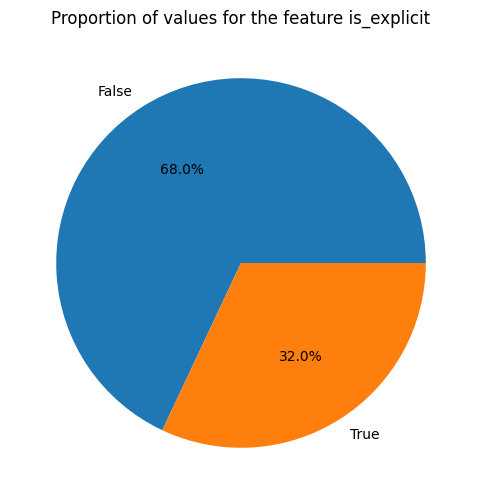

In [20]:
analyze_cat_values(univ_cat_df, "is_explicit")

- There are more non-explicit songs (68%) than Explicit ones (32%)

##### Univariate Analysis - continent

Proportion table for continent: 


,count,proportion
continent,,
EU,911527,0.42
AS,529443,0.24
NA,278991,0.13
SA,277075,0.13
AF,111260,0.05
OC,55531,0.03


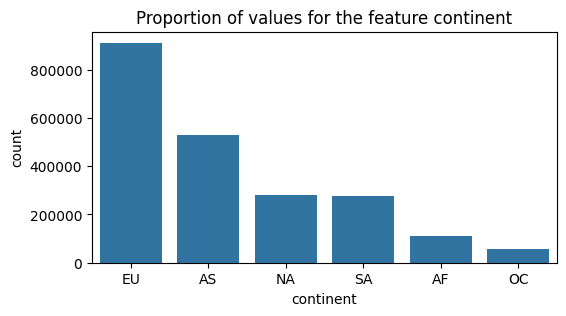

In [21]:
analyze_cat_values(univ_cat_df, "continent")

- The preferences per country are mainly from EU (42%), followed by Asia (24%).

##### Univariate Analysis - mode

Proportion table for mode: 


,count,proportion
mode,,
1,1125662,0.52
0,1038165,0.48


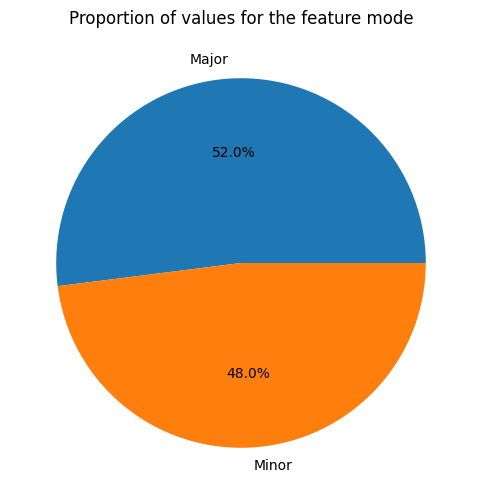

In [27]:
analyze_cat_values(univ_cat_df, "mode", ax_labels = ["Major", "Minor"])

Mode values are {0: "Minor", 1: "Major"}
- While its very close, there are more songs with a Major Mode (52%) than Minor Mode (48%)

##### Univariate Analysis - popularity

Proportion table for popularity: 


,count,proportion
popularity,,
87,71554,0.03
88,69865,0.03
89,67477,0.03
86,66151,0.03
90,63201,0.03
...,...,...
6,148,0.00
5,144,0.00
10,142,0.00


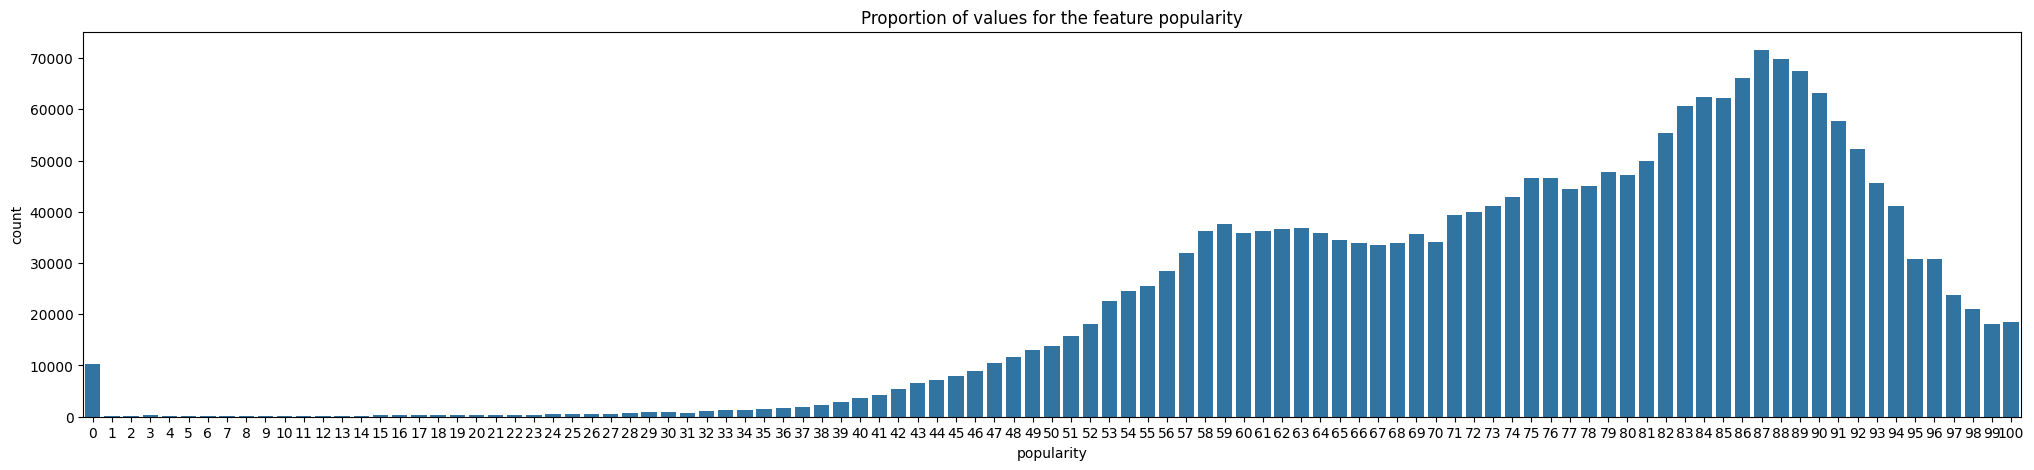

In [162]:
analyze_cat_values(univ_cat_df, "popularity", chart_size=(25,5))

In Popularity I was expecting less representation on low values due to the nature of the dataset but we have a brought representation:
- Has a small representation for values=0 and any in between 1 and 21.
- It start having more representation from 21.
- There are 3 major picks of 59, 75 and 87 (being this one the highest)

##### Univariate Analysis - key

Proportion table for key: 


,count,proportion
key,,
1,253709,0.12
11,216266,0.10
7,204401,0.09
9,201977,0.09
6,199592,0.09
0,199557,0.09
5,185073,0.09
2,182761,0.08
8,162882,0.08


/mnt/data/Synology/Home/Documents/Formacion/DataScience/_IronHack/05-Projects/W3-project-2-eda-sql/data_analysis_helpers.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax_labels, rotation=0)


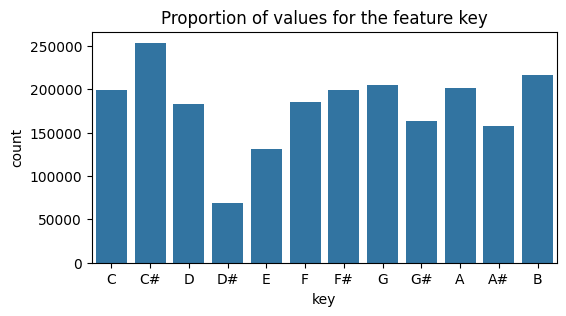

In [163]:
analyze_cat_values(univ_cat_df, "key", ax_labels=["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"])

Key Values are `{0:"C", 1:"C#", 2:"D", 3:"D#", 4:"E", 5:"F", 6:"F#", 7:"G", 8:"G#", 9:"A", 10:"A#", 11:"B"}`
- the lest common one is D#, 
- followed by E, G# and L# that has similar representation
- The rest of the key has also a similar representation except for...
- C# is the most common key (12%)

##### Univariate Analysis - time_signature

Proportion table for time_signature: 


,count,proportion
time_signature,,
4,1934641,0.89
3,181775,0.08
5,31234,0.01
1,16176,0.01
0,1,0.00


/mnt/data/Synology/Home/Documents/Formacion/DataScience/_IronHack/05-Projects/W3-project-2-eda-sql/data_analysis_helpers.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax_labels, rotation=0)


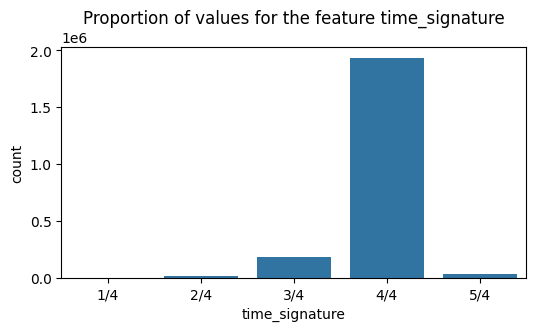

In [28]:
analyze_cat_values(univ_cat_df, "time_signature", ax_labels=["1/4", "2/4", "3/4", "4/4", "5/4"])

Time Signatures expected values are `{3:"3/4", 4:"4/4", 5:"5/4", 6: "6/4", 7: "7/4"}`
- It is strange to see values 0 and 1 since, based on the Spotify documentation, values should go in between 3 and 7 but these represent a very low percentage (~1%) so I will not focus on them at this time. 
- The most common time signature is 4/4 (89%) and 3/4 (8%), an expected result.

#### Numeric Features Review

In [165]:
"""
# Version removing duplicated songs (not ready, generates some troubles later)
# Analyze numerical values
univ_num_df = num.copy()
# Excluding values analysed in the step before
univ_num_df.drop(columns=univ_cat_df.columns, inplace=True, errors="ignore")
# Also drop columns related to rank since I am not planningg to use them in the Analysis
univ_num_df.drop(columns=["daily_rank", "daily_movement", "weekly_movement"], inplace=True, errors="ignore")

univ_num_df = songs_df[["spotify_id"]].merge(univ_num_df,how="inner", left_index=True, right_index=True)
#display(univ_num_df.groupby("spotify_id").mean()) #23891

univ_num_df.drop_duplicates(keep="first", inplace=True) # 24425
#univ_num_df.reset_index(inplace=True)


freq = getFrequencyTable(univ_num_df, "spotify_id")
univ_num_df[univ_num_df["spotify_id"].isin(freq[freq["count"] > 1].index)].sort_values("spotify_id")
univ_num_df = univ_num_df.drop(columns=["spotify_id", "index"], axis=0)
"""

# Analyze numerical values
univ_num_df = num.copy()
# Excluding values analysed in the step before
univ_num_df.drop(columns=univ_cat_df.columns, inplace=True, errors="ignore")
# Also drop columns related to rank since I am not planningg to use them in the Analysis
univ_num_df.drop(columns=["daily_rank", "daily_movement", "weekly_movement"], inplace=True, errors="ignore")

# Check the statistical measures for thes values
pd.set_option('display.float_format','{:,.2f}'.format) 

display(univ_num_df)

,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
50,349910,0.34,0.54,-9.07,0.06,0.29,0.28,0.21,0.75,176.76
51,467145,0.51,0.43,-11.19,0.05,0.58,0.37,0.11,0.56,118.06
52,408813,0.81,0.54,-7.80,0.05,0.01,0.00,0.05,0.29,118.05
53,224187,0.85,0.68,-10.33,0.07,0.09,0.00,0.04,0.81,127.05
54,327451,0.74,0.46,-10.96,0.05,0.17,0.20,0.10,0.52,118.01
...,...,...,...,...,...,...,...,...,...,...
2023914,310490,0.48,0.41,-9.24,0.05,0.51,0.00,0.26,0.10,88.88
2023915,173253,0.77,0.64,-5.06,0.05,0.06,0.00,0.13,0.48,121.88
2023916,184791,0.57,0.42,-7.62,0.07,0.55,0.00,0.10,0.69,124.36
2023917,179560,0.63,0.45,-8.02,0.09,0.74,0.00,0.15,0.28,74.83


##### Univariate Analysis - duration_ms

Statistic values for duration_ms:
Count:		 2052083
AVG:		 193782.9539195052
Min:		 0
Quantile 25:	 162018.0
Quantile 50:	 186000.0
Quantile 75:	 218423.0
Max:		 1114155
Mode:		 [210373]
Variance:	 2484721320.256809
STD:		 49846.97904845197
Skewness:	 1.8437247426978627
Kurtosis:	 11.581052479886168


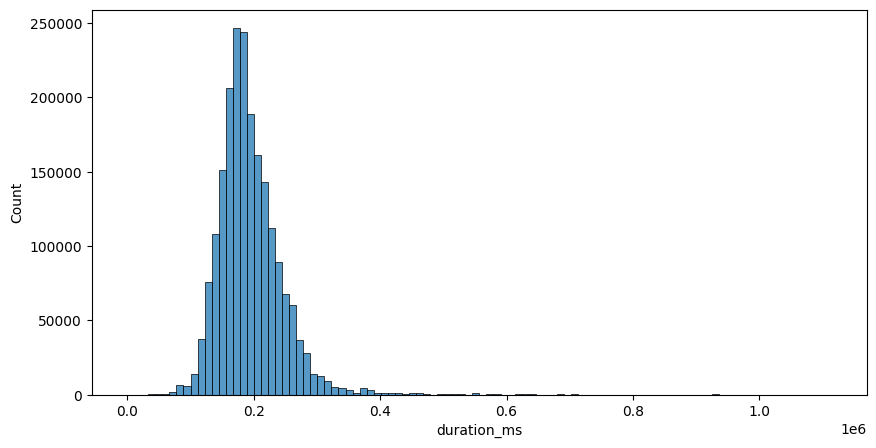

In [166]:
# Review duration_ms
analyze_num_values(univ_num_df, "duration_ms")

- Majority of the song are in between 2.7min (162018ms) and 3.64min (218423.0ms) but the most repeated is 3.5min (210373)
- The song duration has a long and fat tail to the right as confirmed with the positive skewness (1.84) and the high kurtosis > 3 (11.5)
- The longest song is 18.57min (1114155ms) so 25% of the values goes from 3.64 to 18.57min.

##### Univariate Analysis - danceability

Statistic values for danceability:
Count:		 2052083
AVG:		 0.6770915498057339
Min:		 0.0
Quantile 25:	 0.582
Quantile 50:	 0.7
Quantile 75:	 0.78
Max:		 0.988
Mode:		 [0.747]
Variance:	 0.02049774983470418
STD:		 0.1431703524990568
Skewness:	 -0.6365803509102558
Kurtosis:	 0.2757234406438287


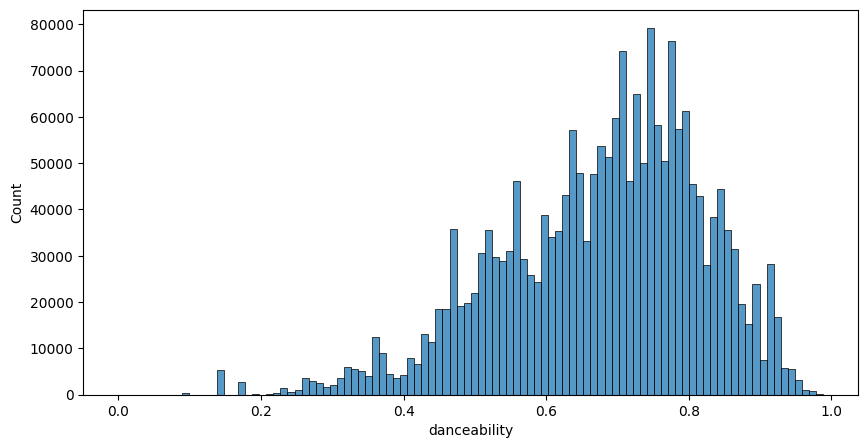

In [167]:
# Review danceability
analyze_num_values(univ_num_df, "danceability")


- Danceability is a value between 0 and 1 
- The curve shows a left tail. The negative skewness (-0.63) confirm that and Kurtosis < 3 (0.27) indicates a thin tail with low outlaiers fequency.
- Majority of the values are in between 0.58 and 0.78. Being the middle point 0.7
- The most repeated value is 0.747

##### Univariate Analysis - energy

Statistic values for energy:
Count:		 2052083
AVG:		 0.6481478175306263
Min:		 2.01e-05
Quantile 25:	 0.551
Quantile 50:	 0.668
Quantile 75:	 0.766
Max:		 0.998
Mode:		 [0.507]
Variance:	 0.028275316792056047
STD:		 0.1681526591881795
Skewness:	 -0.6872991586281872
Kurtosis:	 0.6547317548204519


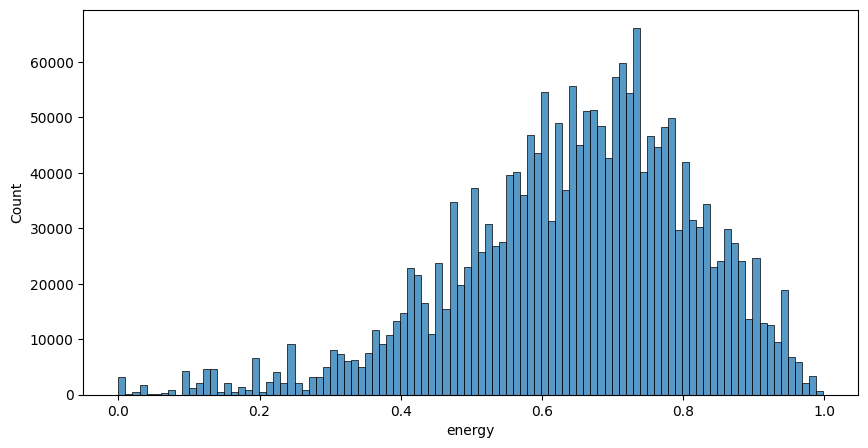

In [168]:
# Review energy
analyze_num_values(univ_num_df, "energy")

- Energy represents the quantity of activity 
- Majority of the songs are in between 0.551 and 0.766.
- The most frequent energy value is 0.507
- The distribution shows a tail to the left (negative skewness) and a thin tail with low outlaiers (kurtosis < 3)

##### Univariate Analysis - loudness

Statistic values for loudness:
Count:		 2052083
AVG:		 -6.765551688698757
Min:		 -54.341
Quantile 25:	 -7.877
Quantile 50:	 -6.089
Quantile 75:	 -4.75
Max:		 3.233
Mode:		 [-10.171]
Variance:	 14.093137524550258
STD:		 3.7540827807269057
Skewness:	 -4.364373758199053
Kurtosis:	 32.91694638587402


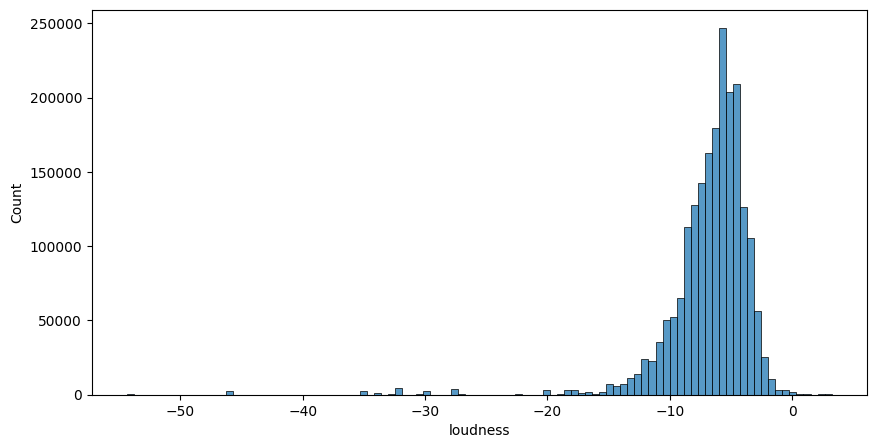

In [169]:
# Review loudness
analyze_num_values(univ_num_df, "loudness")

- Loudness is a negative value that measures the avg volumen of the song.
- The most common values are in betweem -7.877 and -4.75 but the most repeated value (-10.171) is out of that range (I assume because of the tipe of measure makes difficult to have the same exact value many times)
- 

\#TODO: Finish Analisys 

##### Univariate Analysis - speechiness

Statistic values for speechiness:
Count:		 2052083
AVG:		 0.09605998607268802
Min:		 0.0
Quantile 25:	 0.0387
Quantile 50:	 0.0584
Quantile 75:	 0.112
Max:		 0.955
Mode:		 [0.0358]
Variance:	 0.008439889735493228
STD:		 0.09186887250583425
Skewness:	 2.2254838015212526
Kurtosis:	 5.723863406240658


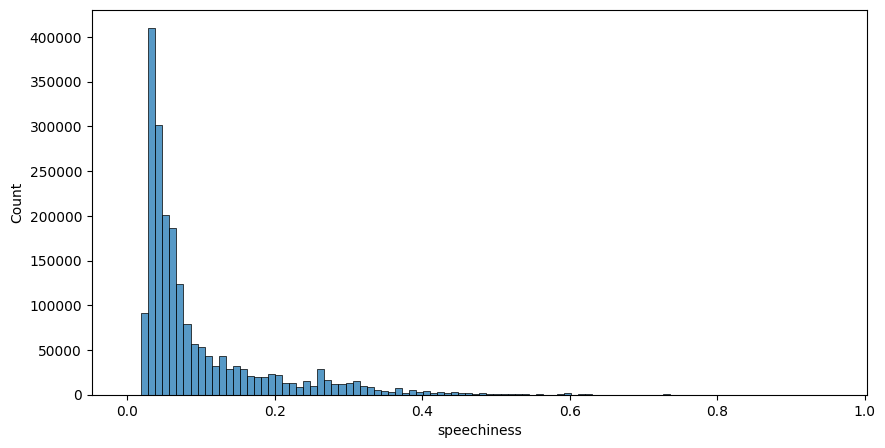

In [170]:
# Review speechiness
analyze_num_values(univ_num_df, "speechiness")

\#TODO: Analisys 

##### Univariate Analysis - acousticness

Statistic values for acousticness:
Count:		 2052083
AVG:		 0.27564909784962405
Min:		 3.45e-06
Quantile 25:	 0.0678
Quantile 50:	 0.192
Quantile 75:	 0.437
Max:		 0.996
Mode:		 [0.2]
Variance:	 0.0626535583200859
STD:		 0.2503069282302947
Skewness:	 0.9294218894121263
Kurtosis:	 -0.13554833532581423


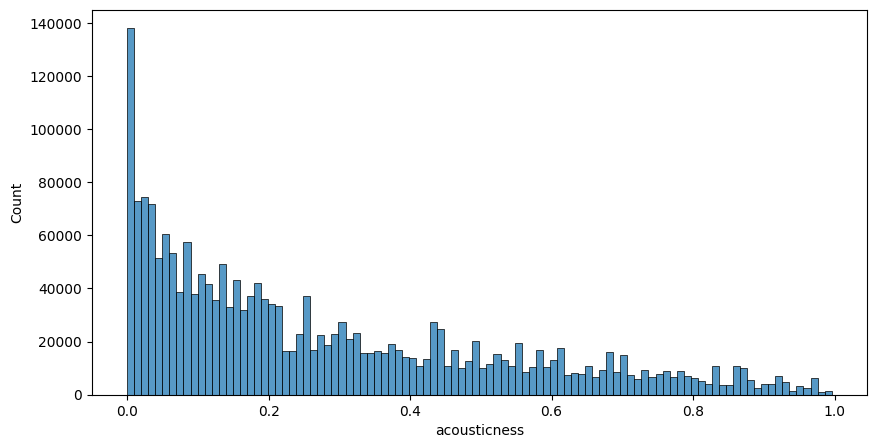

In [171]:
# Review acousticness
analyze_num_values(univ_num_df, "acousticness")

\#TODO: Analisys 

##### Univariate Analysis - instrumentalness

Statistic values for instrumentalness:
Count:		 2052083
AVG:		 0.02275079450335099
Min:		 0.0
Quantile 25:	 0.0
Quantile 50:	 1.35e-06
Quantile 75:	 0.000101
Max:		 0.995
Mode:		 [0.0]
Variance:	 0.012688967887939245
STD:		 0.11264531897926006
Skewness:	 6.334943026881902
Kurtosis:	 42.29152116556311


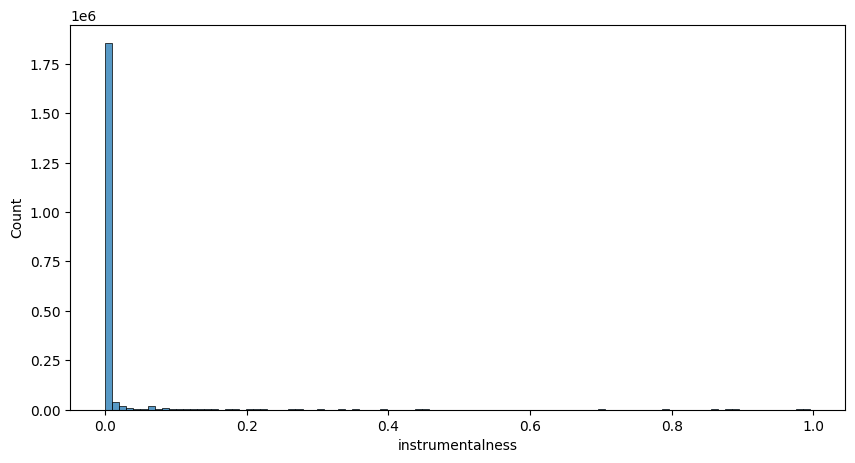

In [172]:
# Review instrumentalness
analyze_num_values(univ_num_df, "instrumentalness")

\#TODO: Analisys 

##### Univariate Analysis - liveness

Statistic values for liveness:
Count:		 2052083
AVG:		 0.17088692645472922
Min:		 0.0139
Quantile 25:	 0.0961
Quantile 50:	 0.122
Quantile 75:	 0.204
Max:		 0.983
Mode:		 [0.104]
Variance:	 0.01555724528993624
STD:		 0.12472868671615299
Skewness:	 2.3443427456145858
Kurtosis:	 7.243036117203139


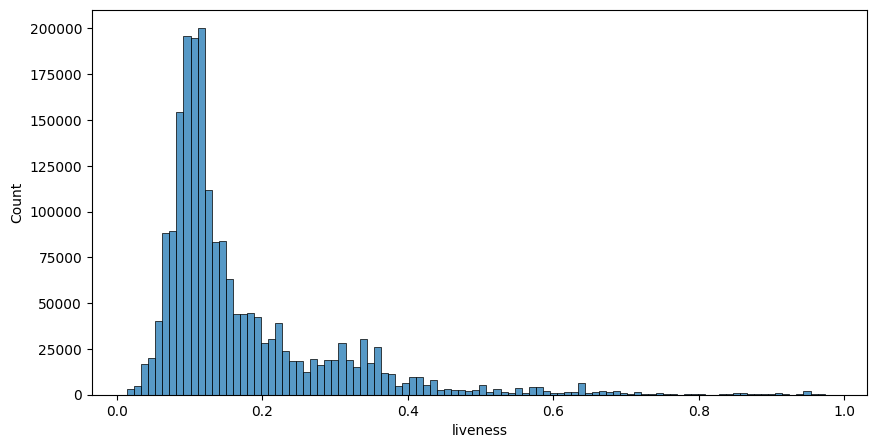

In [173]:
# Review liveness
analyze_num_values(univ_num_df, "liveness")

\#TODO: Analisys 

##### Univariate Analysis - valence

Statistic values for valence:
Count:		 2052083
AVG:		 0.5464236231867817
Min:		 0.0
Quantile 25:	 0.37
Quantile 50:	 0.548
Quantile 75:	 0.732
Max:		 0.992
Mode:		 [0.535]
Variance:	 0.05319157975384821
STD:		 0.23063299797264095
Skewness:	 -0.08670460321725208
Kurtosis:	 -0.8935755951303213


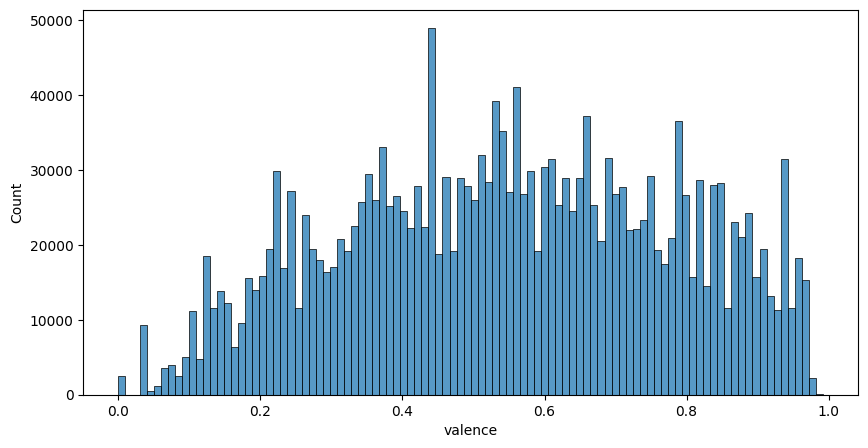

In [174]:
# Review valence
analyze_num_values(univ_num_df, "valence")

\#TODO: Analisys 

##### Univariate Analysis - tempo

Statistic values for tempo:
Count:		 2052083
AVG:		 121.99293018703437
Min:		 0.0
Quantile 25:	 100.019
Quantile 50:	 119.96
Quantile 75:	 140.019
Max:		 236.089
Mode:		 [104.978]
Variance:	 777.4465622472835
STD:		 27.88272874464197
Skewness:	 0.48628728438337016
Kurtosis:	 -0.21021798978439588


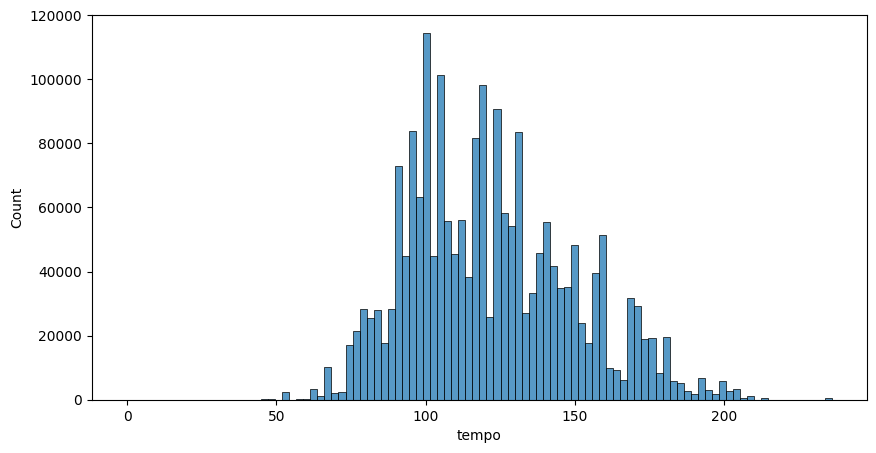

In [175]:
# Review tempo
analyze_num_values(univ_num_df, "tempo")

#### Univariate Analysis Conclusions
- To songs trend to have a duration in between 3 and 4 min
- To songs trends to be danceable
- 
\#TODO: Finish Analisys 

**Doubts**:
- Shall I split the DataFrame in songs_info (properties of the song) and songs_poularity (popularity, location, rank, etc...) to have a better analysis?


## Bivariate Analysis
- How Categorical Features relate with each other

In [176]:
# Review columns
display(univ_cat_df)
display(univ_num_df)

,is_explicit,continent,mode,popularity,key,time_signature
50,False,AF,0,72,10,3
51,False,AF,1,68,1,4
52,False,AF,0,62,11,4
53,False,AF,1,69,11,4
54,False,AF,0,69,4,4
...,...,...,...,...,...,...
2023914,True,AS,0,84,5,3
2023915,True,AS,1,80,10,4
2023916,False,AS,0,88,10,5
2023917,False,AS,0,88,9,4


,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
50,349910,0.34,0.54,-9.07,0.06,0.29,0.28,0.21,0.75,176.76
51,467145,0.51,0.43,-11.19,0.05,0.58,0.37,0.11,0.56,118.06
52,408813,0.81,0.54,-7.80,0.05,0.01,0.00,0.05,0.29,118.05
53,224187,0.85,0.68,-10.33,0.07,0.09,0.00,0.04,0.81,127.05
54,327451,0.74,0.46,-10.96,0.05,0.17,0.20,0.10,0.52,118.01
...,...,...,...,...,...,...,...,...,...,...
2023914,310490,0.48,0.41,-9.24,0.05,0.51,0.00,0.26,0.10,88.88
2023915,173253,0.77,0.64,-5.06,0.05,0.06,0.00,0.13,0.48,121.88
2023916,184791,0.57,0.42,-7.62,0.07,0.55,0.00,0.10,0.69,124.36
2023917,179560,0.63,0.45,-8.02,0.09,0.74,0.00,0.15,0.28,74.83


### Categorical vs Categorical

#### Bivariate Analysis: continent - is_explicit
Busines Question:  What are the countries having more explicit songs?

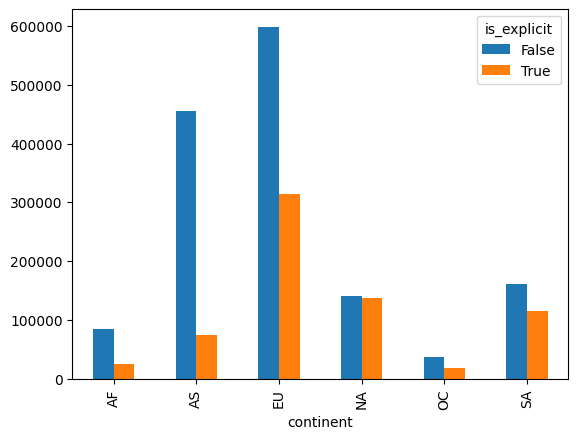

is_explicit,False,True,explicit_rate
continent,,,
NA,140907,138084,49.49
SA,161611,115464,41.67
EU,597878,313649,34.41
OC,37449,18082,32.56
AF,84781,26479,23.80
AS,454729,74714,14.11



Chi-square: 0.00  - Is there significant association? (chi2_pvalue<0.05):  True
Cramér's V: 0.25  - How is the strength of the relation?:  Moderate


In [177]:
crosstab_df = pd.crosstab(index=univ_cat_df["continent"], columns=univ_cat_df["is_explicit"])
ax = crosstab_df.plot(kind='bar', stacked=False)
plt.show()

_, chi2_pvalue, _, _ = chi2_contingency(crosstab_df)
cramer_v = association(crosstab_df, method='cramer')

crosstab_df["explicit_rate"] = crosstab_df[True] * 100 / (crosstab_df[True] + crosstab_df[False])
display(crosstab_df.sort_values("explicit_rate", ascending=False))

print(f"\nChi-square: {chi2_pvalue:.2f}", " - Is there significant association? (chi2_pvalue<0.05): ", isChisquareStrong(chi2_pvalue))
print(f"Cramér's V: {cramer_v:.2f}", " - How is the strength of the relation?: ", getCramervRelation(cramer_v))

While is not the continent with more explicit content in the dataset, North America is the one having more in proportion with a 49.49% of the songs being explicit followed by South America (41.67%) and Europe (34.41)

Chi-square and Cramér's V report a Moderate relation between these two attributes 

#### Bivariate Analysis: key - mode
Busines Question: What are most common keys in Major and Minor mode?

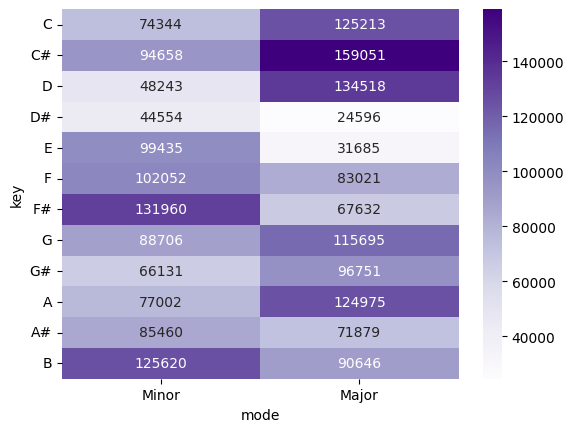

mode,0,1,minor_rate,major_rate
key,,,,
0,74344,125213,37.25,62.75
1,94658,159051,37.31,62.69
2,48243,134518,26.40,73.60
3,44554,24596,64.43,35.57
4,99435,31685,75.84,24.16
5,102052,83021,55.14,44.86
6,131960,67632,66.11,33.89
7,88706,115695,43.40,56.60
8,66131,96751,40.60,59.40



Chi-square: 0.00  - Is there significant association? (chi2_pvalue<0.05):  True
Cramér's V: 0.27  - How is the strength of the relation?:  Moderate


In [178]:
crosstab_df = pd.crosstab(index=univ_cat_df["key"], columns=univ_cat_df["mode"])

ax = sns.heatmap(crosstab_df, annot=True, cmap="Purples", fmt="d")
ax.set_yticklabels(["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"], rotation=0)
ax.set_xticklabels(["Minor", "Major"], rotation=0)
plt.show();

_, chi2_pvalue, _, _ = chi2_contingency(crosstab_df)
cramer_v = association(crosstab_df, method='cramer')

crosstab_df["minor_rate"] = crosstab_df[0] * 100 / (crosstab_df[0] + crosstab_df[1])
crosstab_df["major_rate"] = crosstab_df[1] * 100 / (crosstab_df[0] + crosstab_df[1])

display(crosstab_df.sort_index())
print(f"\nChi-square: {chi2_pvalue:.2f}", " - Is there significant association? (chi2_pvalue<0.05): ", isChisquareStrong(chi2_pvalue))
print(f"Cramér's V: {cramer_v:.2f}", " - How is the strength of the relation?: ", getCramervRelation(cramer_v))

We can see that c# is the most common key for major scale songs, followed by D, C and A.
For the minor scale the most common are F# and B.

Chi-square and Cramér's V report a Moderate relation between these two attributes

#### Bivariate Analysis: key - time_signature

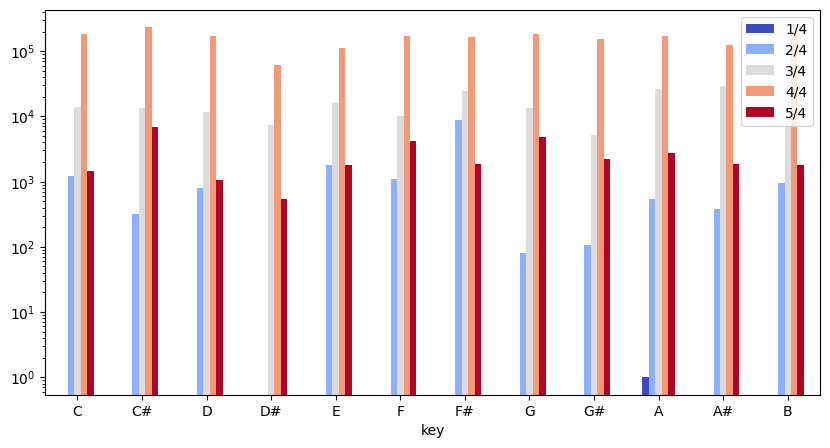

time_signature,0,1,3,4,5
key,,,,,
0,0,1199,14037,182863,1458
1,0,315,13358,233138,6898
2,0,805,11740,169148,1068
3,0,0,7377,61224,549
4,0,1786,16323,111201,1810
5,0,1091,10267,169511,4204
6,0,8914,24200,164644,1834
7,0,80,13507,186018,4796
8,0,107,5221,155294,2260



Chi-square: 0.00  - Is there significant association? (chi2_pvalue<0.05):  True
Cramér's V: 0.11  - How is the strength of the relation?:  Weak


In [179]:
crosstab_df = pd.crosstab(index=univ_cat_df["key"], columns=univ_cat_df["time_signature"])

ax = crosstab_df.plot(kind='bar', stacked=False, figsize=(10,5), cmap="coolwarm")
ax.set_yscale('log')
ax.set_xticklabels(["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"], rotation=0)
ax.legend(["1/4", "2/4", "3/4", "4/4", "5/4"])
plt.show();

_, chi2_pvalue, _, _ = chi2_contingency(crosstab_df)
cramer_v = association(crosstab_df, method='cramer')

display(crosstab_df.sort_index())
print(f"\nChi-square: {chi2_pvalue:.2f}", " - Is there significant association? (chi2_pvalue<0.05): ", isChisquareStrong(chi2_pvalue))
print(f"Cramér's V: {cramer_v:.2f}", " - How is the strength of the relation?: ", getCramervRelation(cramer_v))

Therere is relation but it is weak. 
The weak relation is probably because big majority of the songs are in 4/4.

#### Bivariate Analysis: mode - time_signature

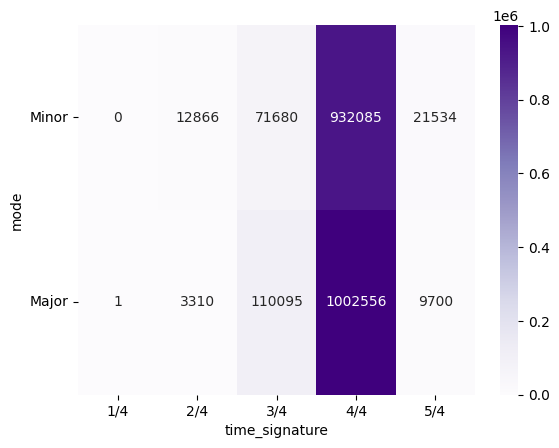

time_signature,0,1,3,4,5
mode,,,,,
0,0,12866,71680,932085,21534
1,1,3310,110095,1002556,9700



Chi-square: 0.00  - Is there significant association? (chi2_pvalue<0.05):  True
Cramér's V: 0.09  - How is the strength of the relation?:  Negligible


In [180]:
crosstab_df = pd.crosstab(index=univ_cat_df["mode"], columns=univ_cat_df["time_signature"])

ax = sns.heatmap(crosstab_df, annot=True, cmap="Purples", fmt="d")
ax.set_xticklabels(["1/4", "2/4", "3/4", "4/4", "5/4"], rotation=0)
ax.set_yticklabels(["Minor", "Major"], rotation=0)
plt.show();

_, chi2_pvalue, _, _ = chi2_contingency(crosstab_df)
cramer_v = association(crosstab_df, method='cramer')

display(crosstab_df.sort_index())
print(f"\nChi-square: {chi2_pvalue:.2f}", " - Is there significant association? (chi2_pvalue<0.05): ", isChisquareStrong(chi2_pvalue))
print(f"Cramér's V: {cramer_v:.2f}", " - How is the strength of the relation?: ", getCramervRelation(cramer_v))

Similar to the previous relation, this one is Negligible probabl probably because big majority of the songs are in 4/4.

### Categorical vs Continuous

#### Bivariate Analysis: popularity - continent
Business Question: How is populatiy influenced by the Country?

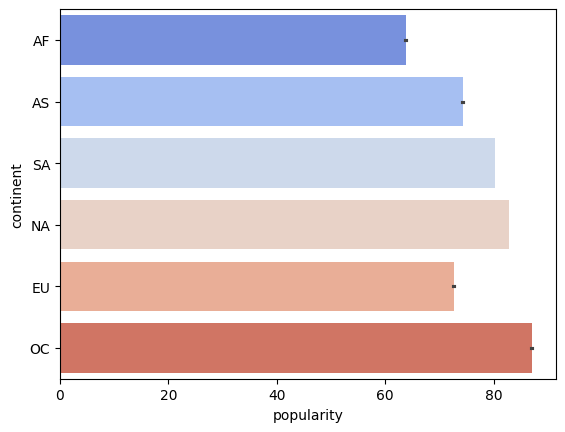

In [181]:
sns.barplot(data=univ_cat_df, x="popularity", y="continent", hue="continent", palette="coolwarm", legend=False)
plt.show();

We can see that that Oceania is where the songs have high popularity. It is also where the valies seems more condensed (leaving outside outliers)
In contrast Europe has much more dispersion on the popularity of these songs.
Africa is the continent where the songs in the dataset has less popularity

#### Bivariate Analysis: popularity - mode
Bunsiness Question: What mode makes songs more popular?

/tmp/ipykernel_9663/3573532410.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Minor", "Major"]);


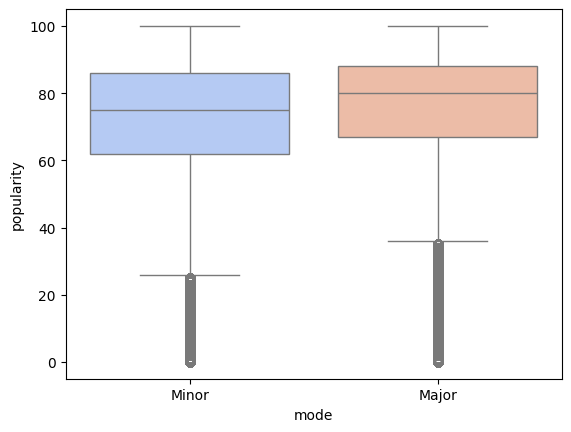

In [182]:
ax = sns.boxplot(data=univ_cat_df, y="popularity", x="mode", hue="mode", palette="coolwarm", legend=False);
ax.set_xticklabels(["Minor", "Major"]);
plt.show();

The relation between mode and popularity shows that Major scale songs are more popular than Minor but, the 25 and 75 percentiles are not too far away from each other (specially the second one).

#### Bivariate Analysis: popularity - key
Business Question:  What key makes song more popular?


/tmp/ipykernel_9663/2022010787.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"])


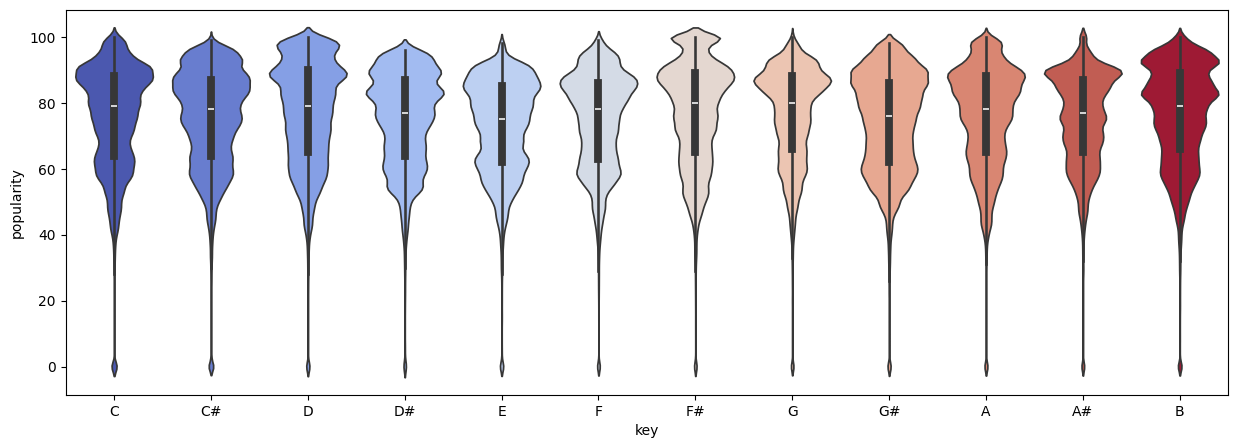

In [183]:
plt.figure(figsize=(15,5))
ax = sns.violinplot(data=univ_cat_df, y="popularity", x="key", hue="key",palette="coolwarm", legend=False);
ax.set_xticklabels(["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"])
plt.show();

While there is a bit of varioation between the different keys, it's value doesn't seem to have a big impact on the popularity

### Continuous vs Continuous

#### Bivariate Analysis: popularity - duration_ms
Business Question:  Is there relation between the song duration and its popularity?

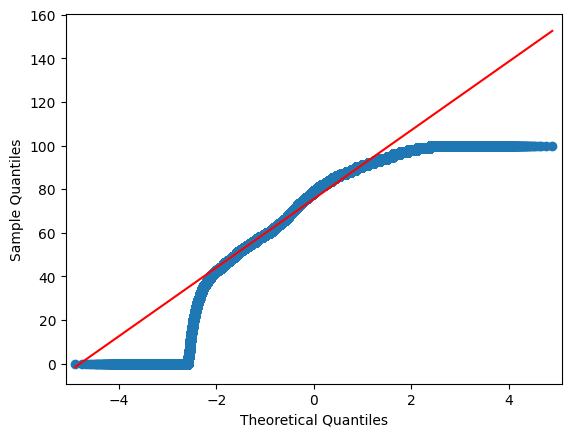

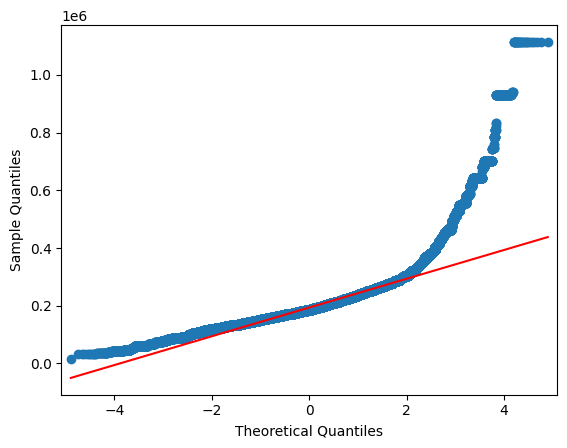

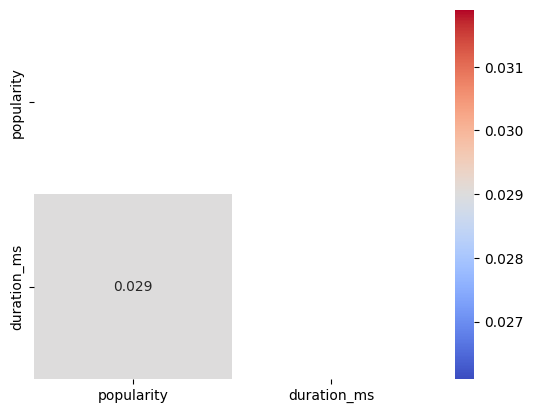

,popularity,duration_ms
popularity,1.00,0.03
duration_ms,0.03,1.00


Parson correlation coeficient: 0.03
Spearman correlation coeficient: 0.07


In [184]:
column1 = "popularity"
column2 = "duration_ms"
tmp_df = songs_df[[column1, column2]].copy()

correlation_matrix = tmp_df.corr()

sm.qqplot(tmp_df[column1], line='s');
plt.show()
sm.qqplot(tmp_df[column2], line='s');
plt.show()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap="coolwarm")
plt.show()

display(correlation_matrix)

# method pearson
parsCorr = round(float(tmp_df[column1].corr(tmp_df[column2], method="pearson")), 2)
# method spearman
spearCorr = round(float(tmp_df[column1].corr(tmp_df[column2], method="spearman")), 2)
print(f"Parson correlation coeficient: {parsCorr:.2f}")
print(f"Spearman correlation coeficient: {spearCorr:.2f}")

Based on the results of the heatmap and the Parson and Spearman correlations we can say there is no correlation between these two features

#### Bivariate Analysis: popularity - danceability
Business Question:  Is there relation between the song danceability and its popularity?

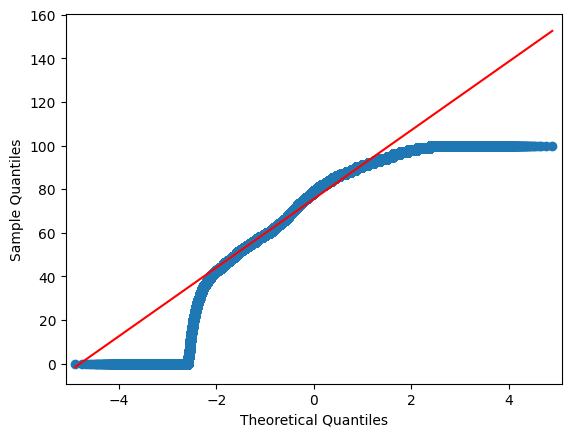

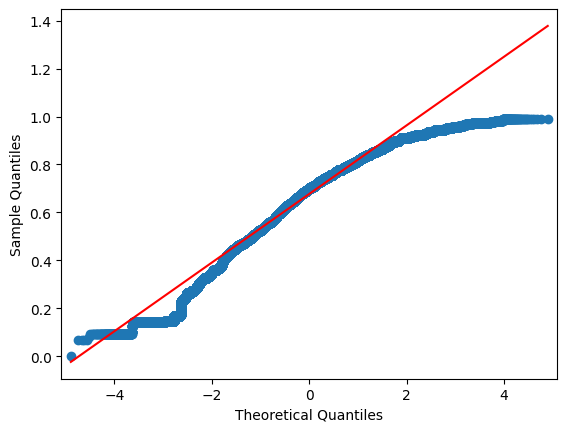

/home/jona/.var/app/com.vscodium.codium/data/python/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


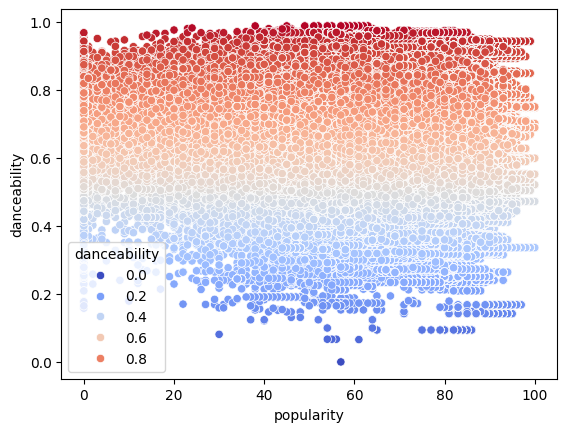

,popularity,danceability
popularity,1.00,-0.05
danceability,-0.05,1.00


Parson correlation coeficient: -0.05
Spearman correlation coeficient: -0.05


In [185]:
column1 = "popularity"
column2 = "danceability"
tmp_df = songs_df[[column1, column2]].copy()

correlation_matrix = tmp_df.corr()

sm.qqplot(tmp_df[column1], line='s');
plt.show()
sm.qqplot(tmp_df[column2], line='s');
plt.show()

sns.scatterplot(data=tmp_df, x=column1, y=column2, hue=column2, palette="coolwarm")
plt.show()

display(correlation_matrix)

# method pearson
parsCorr = round(float(tmp_df[column1].corr(tmp_df[column2], method="pearson")), 2)
# method spearman
spearCorr = round(float(tmp_df[column1].corr(tmp_df[column2], method="spearman")), 2)
print(f"Parson correlation coeficient: {parsCorr:.2f}")
print(f"Spearman correlation coeficient: {spearCorr:.2f}")

These two features seems to have a very small negative correlation (based on the coeficients) but it is very low to be relevant

#### Bivariate Analysis: popularity - energy
Business Question:  Is there relation between the song energy and its popularity?

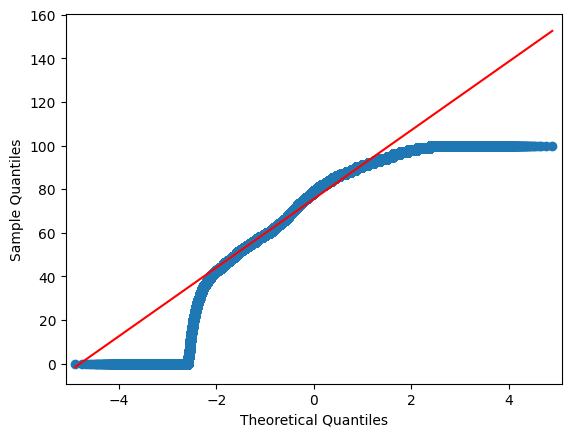

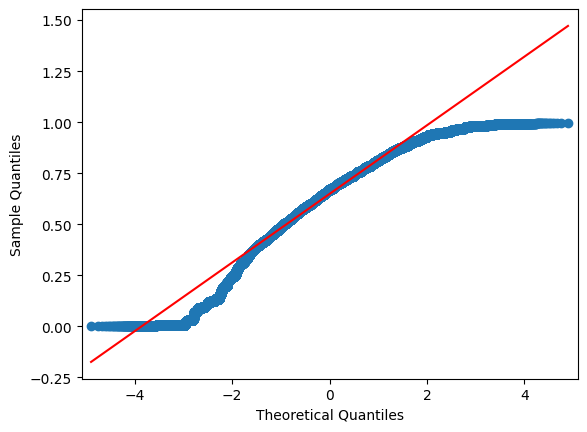

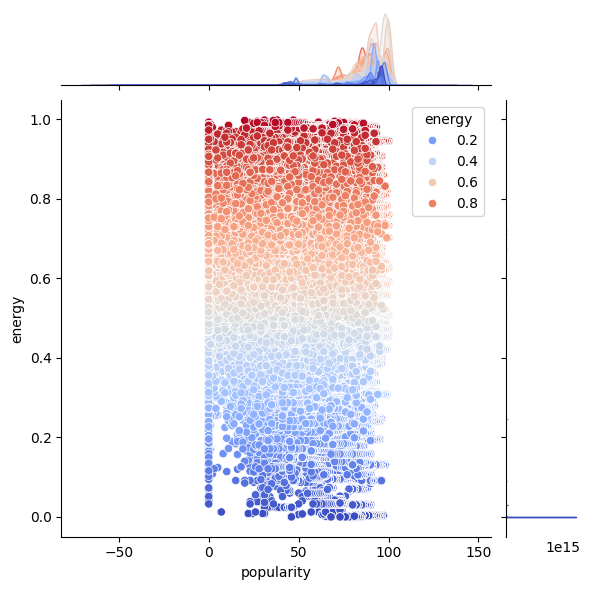

,popularity,energy
popularity,1.00,-0.01
energy,-0.01,1.00


Parson correlation coeficient: -0.01
Spearman correlation coeficient: -0.02


In [186]:
column1 = "popularity"
column2 = "energy"
tmp_df = songs_df[[column1, column2]].copy()

correlation_matrix = tmp_df.corr()

sm.qqplot(tmp_df[column1], line='s');
plt.show()
sm.qqplot(tmp_df[column2], line='s');
plt.show()

sns.jointplot(data=tmp_df, x=column1, y=column2, hue=column2, palette="coolwarm")
plt.show()

display(correlation_matrix)

# method pearson
parsCorr = round(float(tmp_df[column1].corr(tmp_df[column2], method="pearson")), 2)
# method spearman
spearCorr = round(float(tmp_df[column1].corr(tmp_df[column2], method="spearman")), 2)
print(f"Parson correlation coeficient: {parsCorr:.2f}")
print(f"Spearman correlation coeficient: {spearCorr:.2f}")

It seems to not be correlation between popularity and energy

#### Bivariate Analysis: popularity - loudness
Business Question:  Is there relation between the song loudness and its popularity?

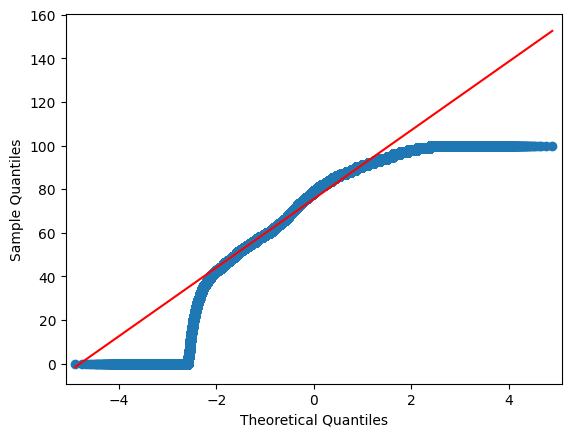

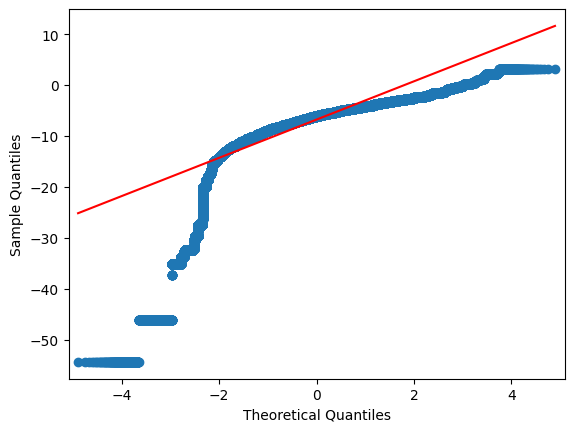

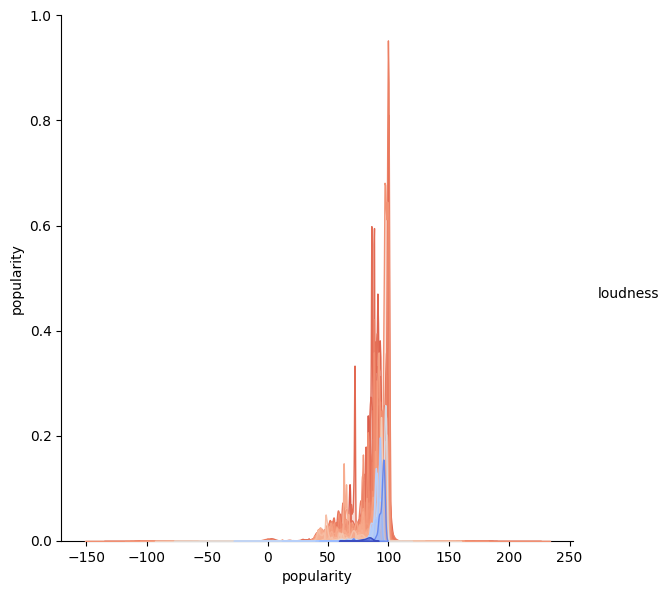

,popularity,loudness
popularity,1.00,0.02
loudness,0.02,1.00


Parson correlation coeficient: 0.02
Spearman correlation coeficient: 0.11


In [187]:
column1 = "popularity"
column2 = "loudness"
tmp_df = songs_df[[column1, column2]].copy()

correlation_matrix = tmp_df.corr()

sm.qqplot(tmp_df[column1], line='s');
plt.show()
sm.qqplot(tmp_df[column2], line='s');
plt.show()

sns.pairplot(tmp_df, hue=column2, palette="coolwarm", height=6)
plt.show()

display(correlation_matrix)

# method pearson
parsCorr = round(float(tmp_df[column1].corr(tmp_df[column2], method="pearson")), 2)
# method spearman
spearCorr = round(float(tmp_df[column1].corr(tmp_df[column2], method="spearman")), 2)
print(f"Parson correlation coeficient: {parsCorr:.2f}")
print(f"Spearman correlation coeficient: {spearCorr:.2f}")

While still far a way of a good correlation we can see that loudness has a bigger (positive) correlation than previous features.

#### Bivariate Analysis: popularity - speechiness
Business Question:  Is there relation between the song speechiness and its popularity?

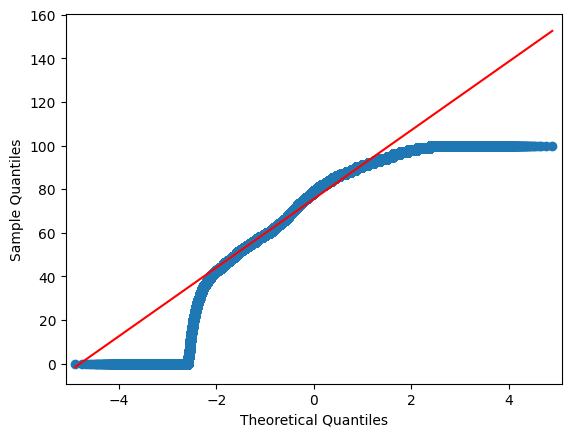

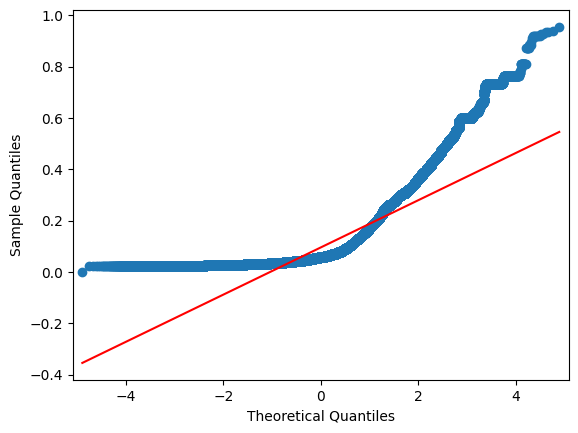

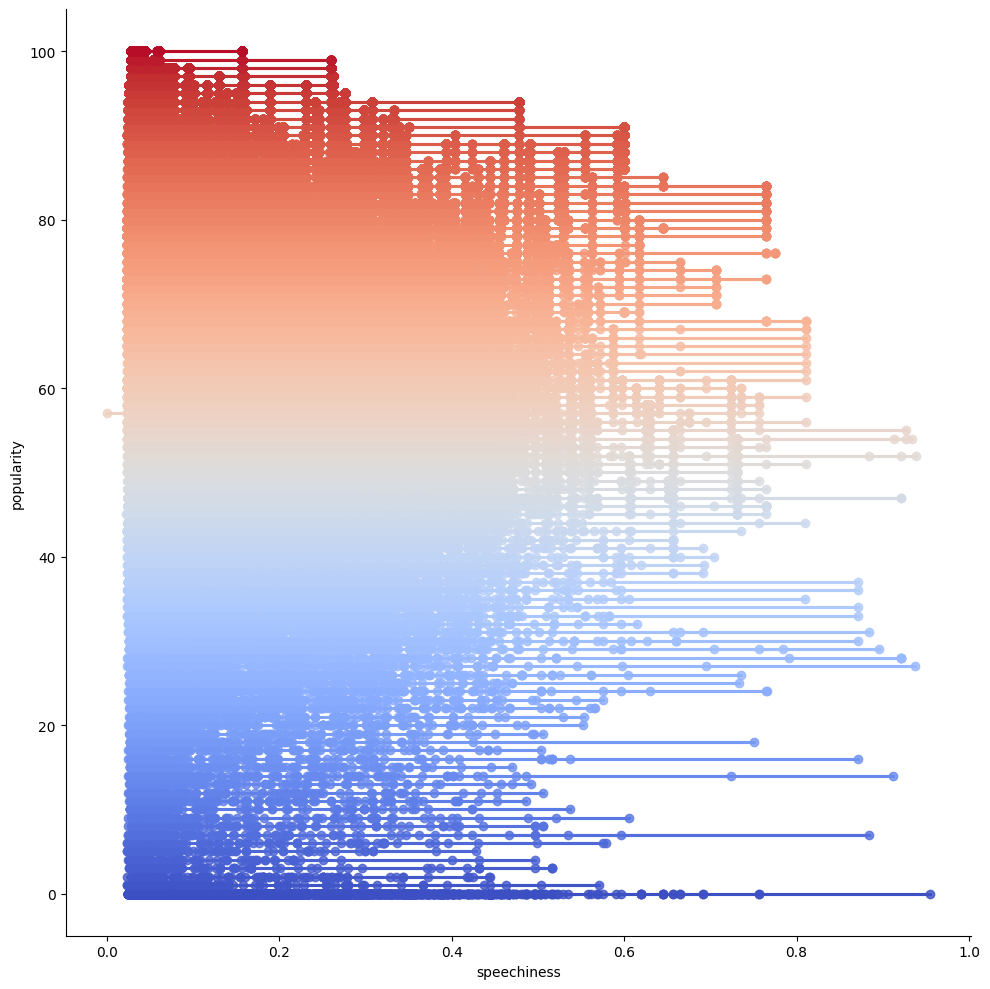

,popularity,speechiness
popularity,1.00,-0.15
speechiness,-0.15,1.00


Parson correlation coeficient: -0.15
Spearman correlation coeficient: -0.17


In [188]:
column1 = "popularity"
column2 = "speechiness"
tmp_df = songs_df[[column1, column2]].copy()

correlation_matrix = tmp_df.corr()

sm.qqplot(tmp_df[column1], line='s');
plt.show()
sm.qqplot(tmp_df[column2], line='s');
plt.show()

sns.lmplot(tmp_df, y=column1, x=column2, hue=column1, palette="coolwarm", legend=False, height=10)
plt.show()

display(correlation_matrix)

# method pearson
parsCorr = round(float(tmp_df[column1].corr(tmp_df[column2], method="pearson")), 2)
# method spearman
spearCorr = round(float(tmp_df[column1].corr(tmp_df[column2], method="spearman")), 2)
print(f"Parson correlation coeficient: {parsCorr:.2f}")
print(f"Spearman correlation coeficient: {spearCorr:.2f}")

We can see a small negative correlation but it's to small to see any linear relationship in the imap chart

#### Bivariate Analysis: popularity - instrumentalness
Business Question:  Is there relation between the song instrumentalness and its popularity?

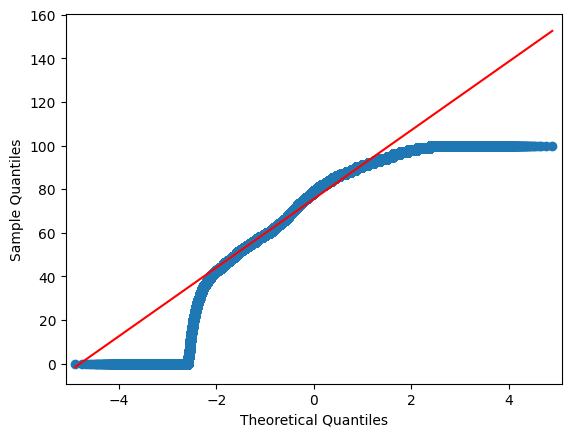

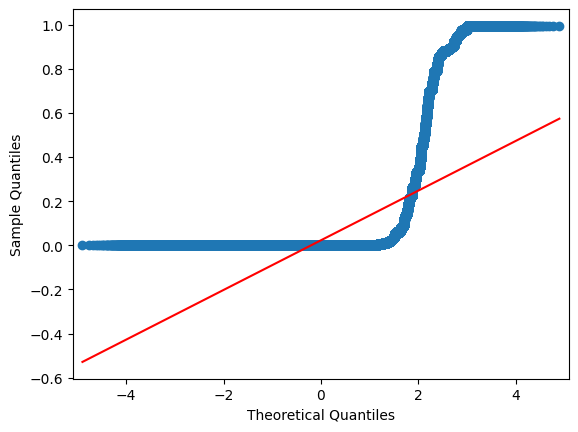

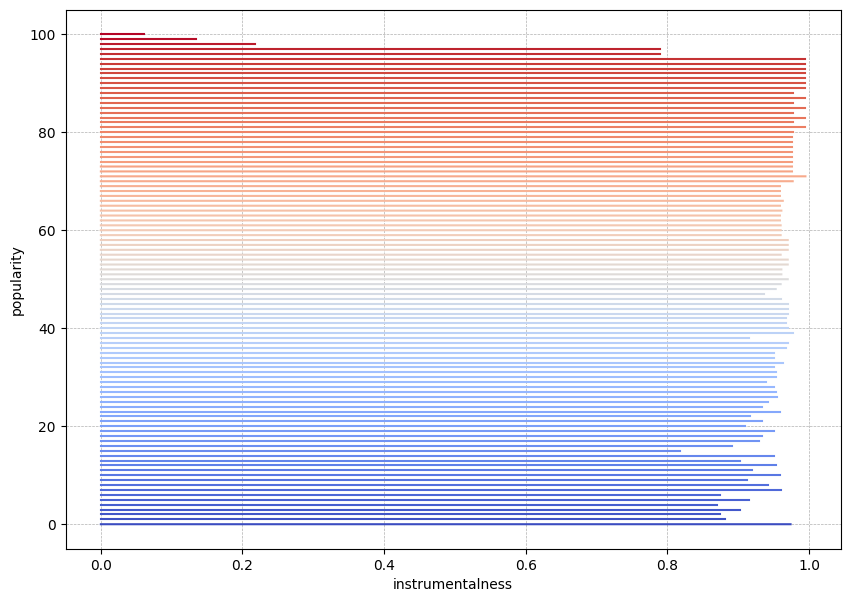

,popularity,instrumentalness
popularity,1.00,0.04
instrumentalness,0.04,1.00


Parson correlation coeficient: 0.04
Spearman correlation coeficient: 0.06


In [189]:
column1 = "popularity"
column2 = "instrumentalness"
tmp_df = songs_df[[column1, column2]].copy()

correlation_matrix = tmp_df.corr()

sm.qqplot(tmp_df[column1], line='s');
plt.show()
sm.qqplot(tmp_df[column2], line='s');
plt.show()

plt.figure(figsize=(10,7))
sns.lineplot(data=tmp_df, y=column1, x=column2, hue=column1, palette="coolwarm", errorbar=None, legend=False)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

display(correlation_matrix)

# method pearson
parsCorr = round(float(tmp_df[column1].corr(tmp_df[column2], method="pearson")), 2)
# method spearman
spearCorr = round(float(tmp_df[column1].corr(tmp_df[column2], method="spearman")), 2)
print(f"Parson correlation coeficient: {parsCorr:.2f}")
print(f"Spearman correlation coeficient: {spearCorr:.2f}")

There is a very low correlation between these features. 

#### Bivariate Analysis: popularity - liveness
Business Question:  Is there relation between the song liveness and its popularity?

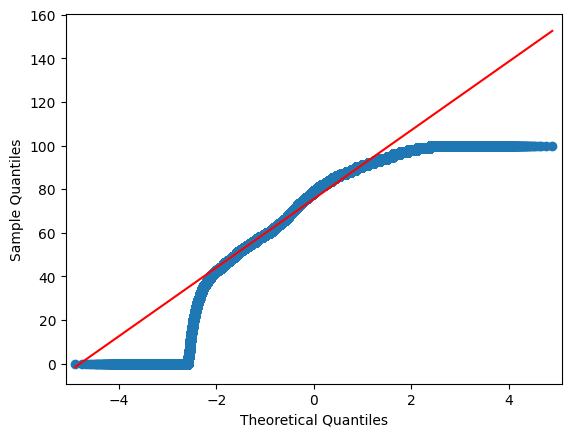

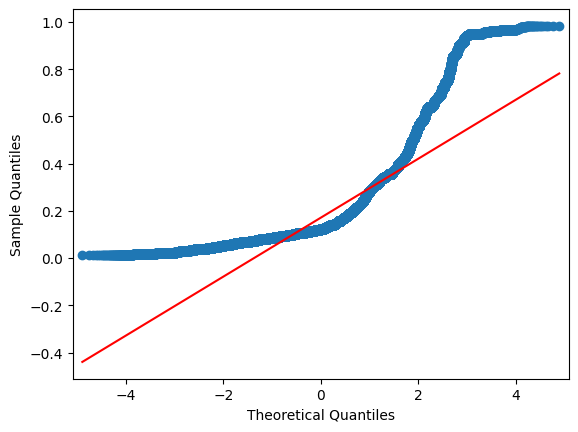

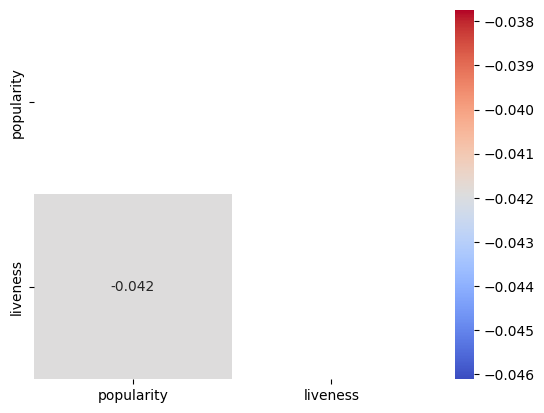

,popularity,liveness
popularity,1.00,-0.04
liveness,-0.04,1.00


Parson correlation coeficient: -0.04
Spearman correlation coeficient: -0.03


In [190]:
column1 = "popularity"
column2 = "liveness"
tmp_df = songs_df[[column1, column2]].copy()

correlation_matrix = tmp_df.corr()

sm.qqplot(tmp_df[column1], line='s');
plt.show()
sm.qqplot(tmp_df[column2], line='s');
plt.show()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap="coolwarm")
plt.show()

display(correlation_matrix)

# method pearson
parsCorr = round(float(tmp_df[column1].corr(tmp_df[column2], method="pearson")), 2)
# method spearman
spearCorr = round(float(tmp_df[column1].corr(tmp_df[column2], method="spearman")), 2)
print(f"Parson correlation coeficient: {parsCorr:.2f}")
print(f"Spearman correlation coeficient: {spearCorr:.2f}")

These featrures have a very small negative relation

#### Bivariate Analysis: popularity - valence
Business Question:  Is there relation between the song valence and its popularity?

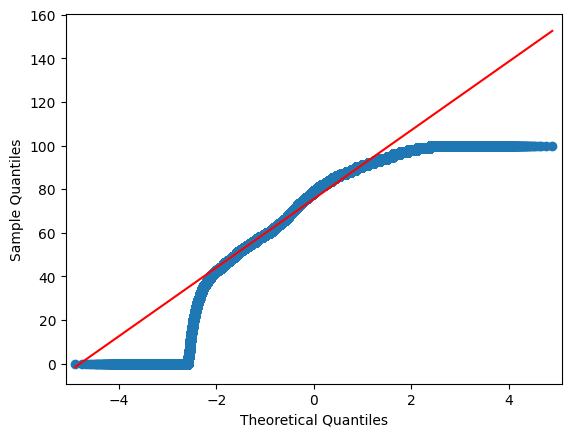

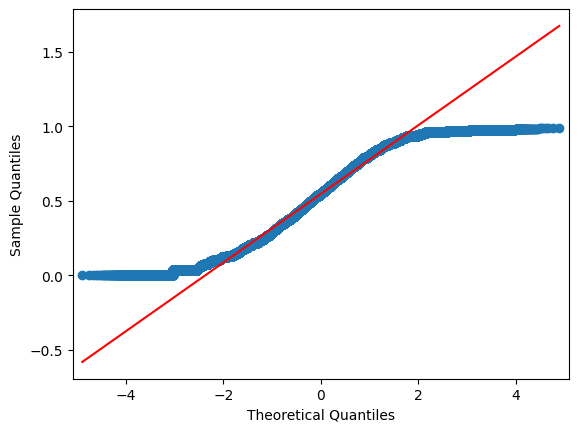

/home/jona/.var/app/com.vscodium.codium/data/python/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


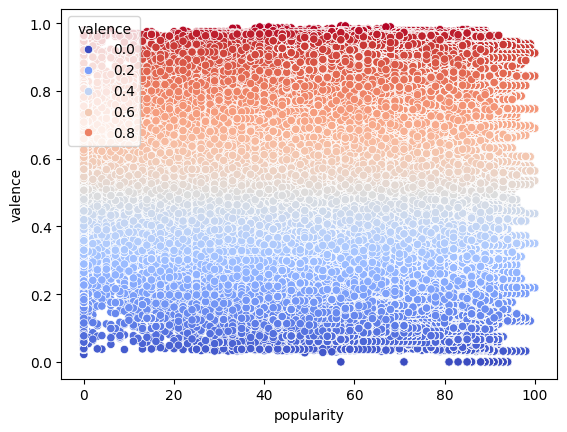

,popularity,valence
popularity,1.00,-0.02
valence,-0.02,1.00


Parson correlation coeficient: -0.02
Spearman correlation coeficient: -0.03


In [191]:
column1 = "popularity"
column2 = "valence"
tmp_df = songs_df[[column1, column2]].copy()

correlation_matrix = tmp_df.corr()

sm.qqplot(tmp_df[column1], line='s');
plt.show()
sm.qqplot(tmp_df[column2], line='s');
plt.show()

sns.scatterplot(data=tmp_df, x=column1, y=column2, hue=column2, palette="coolwarm")
plt.show()

display(correlation_matrix)

# method pearson
parsCorr = round(float(tmp_df[column1].corr(tmp_df[column2], method="pearson")), 2)
# method spearman
spearCorr = round(float(tmp_df[column1].corr(tmp_df[column2], method="spearman")), 2)
print(f"Parson correlation coeficient: {parsCorr:.2f}")
print(f"Spearman correlation coeficient: {spearCorr:.2f}")

These featrures have really small negative relation

#### Bivariate Analysis: popularity - tempo
Business Question:  Is there relation between the song tempo and its popularity?

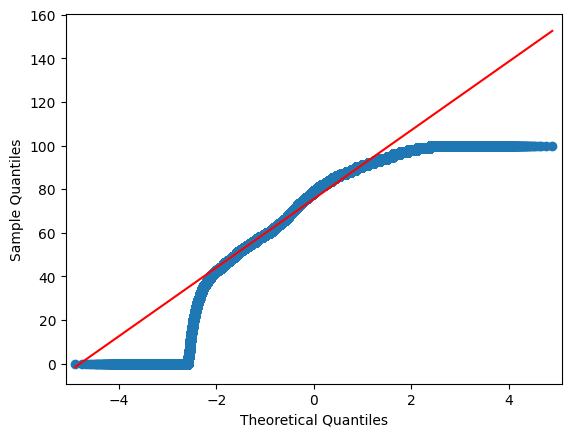

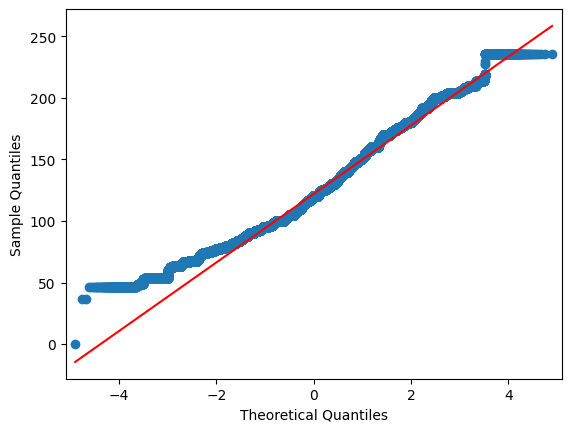

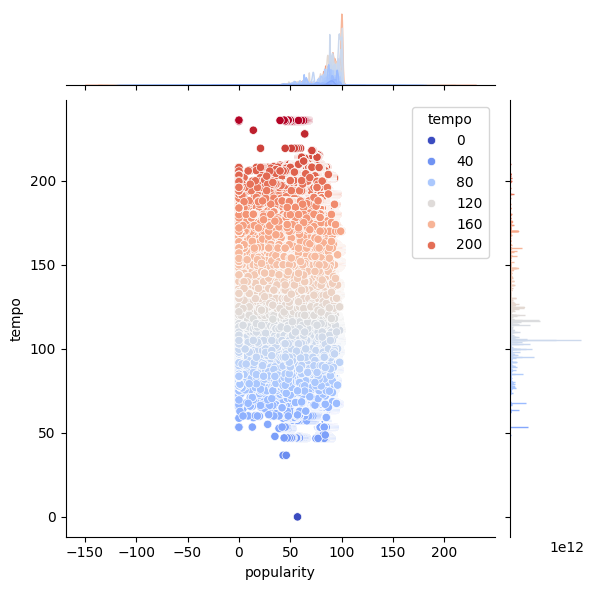

,popularity,tempo
popularity,1.00,-0.00
tempo,-0.00,1.00


Parson correlation coeficient: -0.00
Spearman correlation coeficient: 0.01


In [192]:
column1 = "popularity"
column2 = "tempo"
tmp_df = songs_df[[column1, column2]].copy()

correlation_matrix = tmp_df.corr()

sm.qqplot(tmp_df[column1], line='s');
plt.show()
sm.qqplot(tmp_df[column2], line='s');
plt.show()

sns.jointplot(data=tmp_df, x=column1, y=column2, hue=column2, palette="coolwarm")
plt.show()

display(correlation_matrix)

# method pearson
parsCorr = round(float(tmp_df[column1].corr(tmp_df[column2], method="pearson")), 2)
# method spearman
spearCorr = round(float(tmp_df[column1].corr(tmp_df[column2], method="spearman")), 2)
print(f"Parson correlation coeficient: {parsCorr:.2f}")
print(f"Spearman correlation coeficient: {spearCorr:.2f}")

There is no relation between these metrics

### Analysis:
I didn't found relation between the properties of the songs and its popularity, specially during the last step (continuous vs countinuous).

On the other side we have taken som interesting points on the tendences of the songs:
- Major scale is a bit more common than Minor
- 4/4 is by far the most common Time Signature
- The most common key is C# and the les common D#
- 3.5 min is the most repeated duration for the songs.

### Next Steps:
- I would like to split the data set in 2 and repeat the analysis without song duplications (separate the fields about ranking and popularity from the properties of the songs)
- I would like to get the genere from the songs and do a further analysis about song features and popularity but categorized per genere.


## Database operations (out of the analyis)
In the next cells I'll export the dataset to a sqlite database in order to use it to do the SQL part of the exercise.
I also executed some of the queries in order to create charts for the presentation

In [194]:
# Create a database
con = sqlite3.connect('output/spotify_songs.db')

# Define the DataTypes
dtypes = {'spotify_id':"TEXT", 'name':"TEXT", 'artists':"TEXT", 'daily_rank':"INTEGER", 'daily_movement':"INTEGER", 'weekly_movement': "INTEGER", 'country': "TEXT", 
          'snapshot_date': "INTEGER", 'popularity': "INTEGER", 'is_explicit':"INTEGER", 'duration_ms':"INTEGER", 'album_name':"TEXT", 'album_release_date':"INTEGER",
          'danceability':"REAL", 'energy':"REAL", 'key':"INTEGER", 'loudness':"REAL", 'mode':"INTEGER", 'speechiness':"REAL", 'acousticness':"REAL", 'instrumentalness':"REAL",
          'liveness':"REAL", 'valence':"REAL", 'tempo':"INTEGER", 'time_signature':"INTEGER", 'continent':"TEXT"}

t1_rows = songs_df.to_sql(name="songs", con=con, if_exists="replace", index=True, index_label="id", dtype=dtypes)

print(f"Inserted rows: {t1_rows}")

Inserted rows: 2052052


In [195]:
## TODO: Version for two tables - Need to solve the relation issues after removing duplicated in songs

# Prepare data for inserting in the database
#table_songs = songs_df[["spotify_id", "name", "artists", "is_explicit", "duration_ms", "album_name", "album_release_date", "danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]].copy()
#tmp_df = table_songs.drop_duplicates(keep="first", inplace=True) # I don't delete the indexes because I want them to match the other table
#table_popularity = songs_df[["daily_rank", "daily_movement", "weekly_movement", "country", "continent",  "snapshot_date", "popularity"]].copy()

# Do the export to database
#t1_rows = table_songs.to_sql(name="songs", con=con, if_exists="replace", index=True, index_label="id_song", dtype = {col:dtype for (col, dtype) in dtypes.items() if col in list(table_songs.columns)})
#t2_rows = table_popularity.to_sql(name="popularity", con=con, if_exists="replace", index=True, index_label="id_song", dtype = {col:dtype for (col, dtype) in dtypes.items() if col in list(table_popularity.columns)})

#print(f"Inserted rows: ({t1_rows}, {t2_rows})")
#tmp_df

[75.55255714767462, 72.3472983778844, 83.84178743961353, 74.40898544610842]


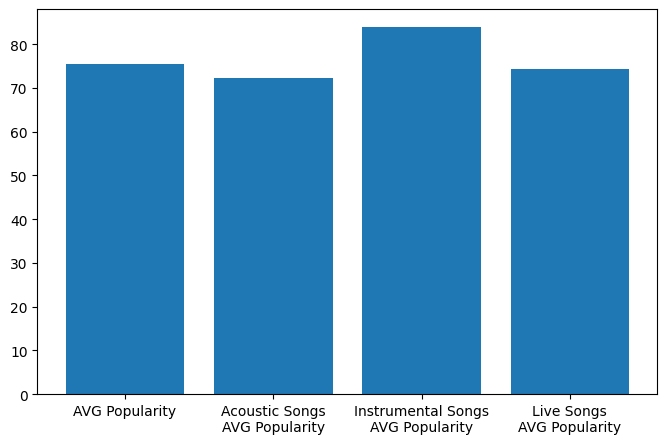

In [196]:
cur = con.cursor()
cur.execute('SELECT (SELECT AVG(popularity) as popularity FROM songs WHERE acousticness >= 0.9) AS acoustic_popularity, (SELECT AVG(popularity) as popularity FROM songs) AS avg_popularity;')
rows = cur.fetchall()
data=[]
data.append(rows[0][1])
data.append(rows[0][0])

cur = con.cursor()
cur.execute('SELECT (SELECT AVG(popularity) as popularity FROM songs WHERE instrumentalness >= 0.9) AS instrumental_popularity,  (SELECT AVG(popularity) as popularity FROM songs) AS avg_popularity;')
rows = cur.fetchall()
data.append(rows[0][0])

cur = con.cursor()
cur.execute('SELECT (SELECT AVG(popularity) as popularity FROM songs WHERE liveness >= 0.9) AS live_popularity , (SELECT AVG(popularity) as popularity FROM songs) AS avg_popularity;')
rows = cur.fetchall()
data.append(rows[0][0])

print(data)

fig, ax = plt.subplots()
fig.set_size_inches(8,5)
ax.bar(["AVG Popularity", "Acoustic Songs\nAVG Popularity", "Instrumental Songs\nAVG Popularity",  "Live Songs\nAVG Popularity"], data)

plt.show()

,duration,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
year,,,,,,,,,,
1900,2.82,0.76,0.53,-8.84,0.04,0.24,0.00,0.20,0.71,137.01
1939,4.93,0.31,0.51,-10.85,0.06,0.94,0.00,0.85,0.45,114.70
1942,2.96,0.32,0.16,-16.48,0.04,0.67,0.35,0.34,0.25,130.50
1945,2.83,0.45,0.26,-13.36,0.06,0.84,0.00,0.32,0.57,140.66
1947,2.50,0.83,0.37,-11.99,0.04,0.80,0.00,0.28,0.98,96.63
...,...,...,...,...,...,...,...,...,...,...
2021,3.40,0.66,0.58,-7.33,0.07,0.41,0.04,0.15,0.46,122.27
2022,3.17,0.66,0.59,-6.95,0.09,0.35,0.01,0.18,0.53,123.31
2023,3.16,0.70,0.66,-6.22,0.10,0.27,0.01,0.17,0.54,121.95


<Axes: xlabel='year'>

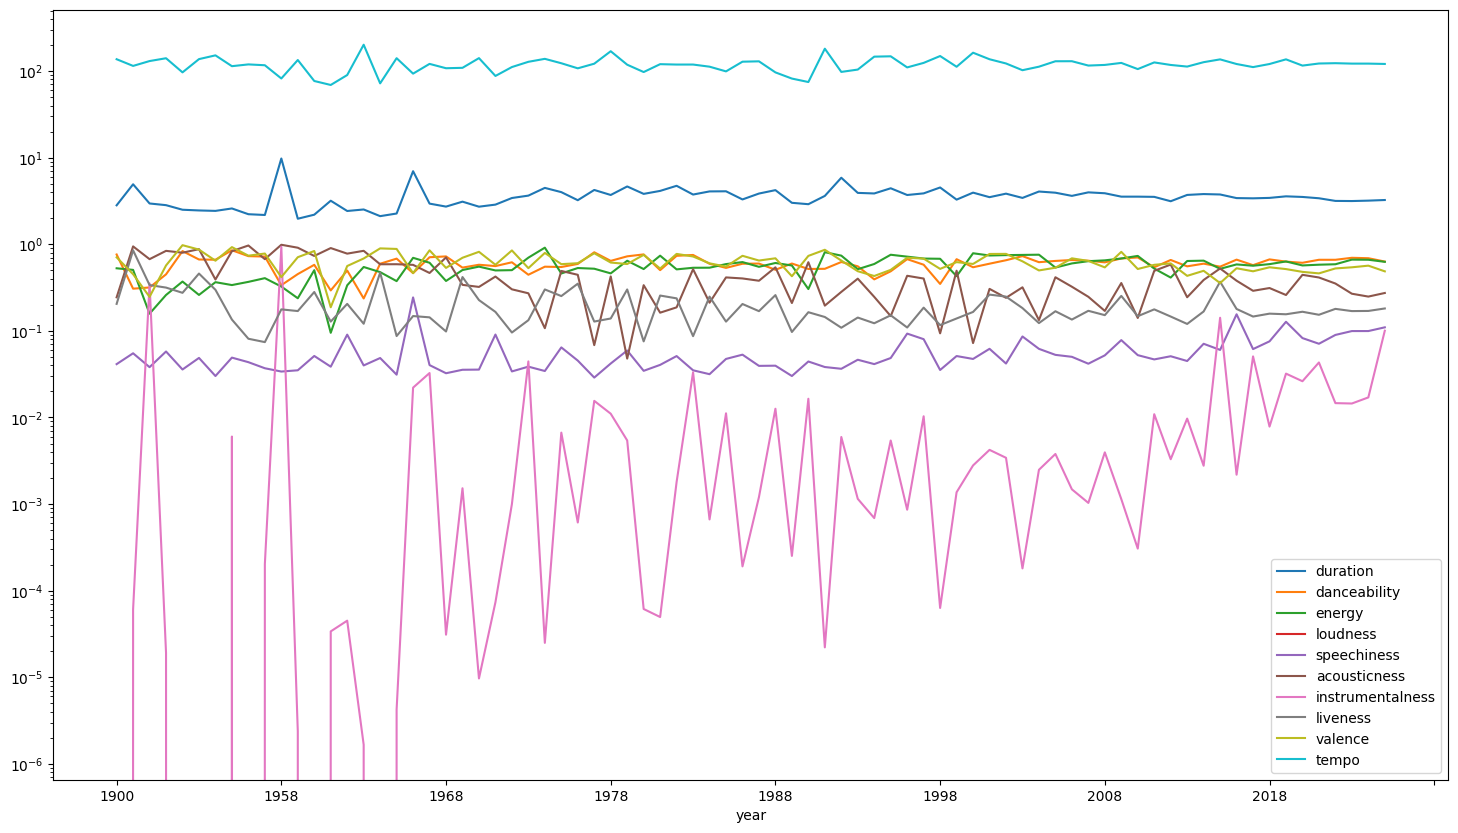

In [222]:
sql = 'SELECT strftime("%Y", datetime("album_release_date")) as year, (AVG("duration_ms") / 60000) as "avg_duration_min", AVG("danceability") as "avg_danceability", AVG("energy") as "avg_energy", AVG("loudness") as "avg_loudness", AVG("speechiness") as "avg_speechiness", AVG("acousticness") as "avg_acousticness", AVG("instrumentalness") as "avg_instrumentalness", AVG("liveness") as "avg_liveness", AVG("valence") as "avg_valence",AVG("tempo") as "avg_tempo" FROM songs GROUP BY year ORDER BY year ASC;'
cur.execute(sql)
rows = cur.fetchall()

tmp_df = pd.DataFrame(rows)
tmp_df.columns = ["year", "duration", "danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo" ]
tmp_df.set_index("year", inplace=True)

display(tmp_df)
tmp_df.plot(kind='line', stacked=False, figsize=(18,10), logy=True)

,popularity
year,
2023,73.07
2024,74.88
2025,71.25


<Axes: xlabel='year'>

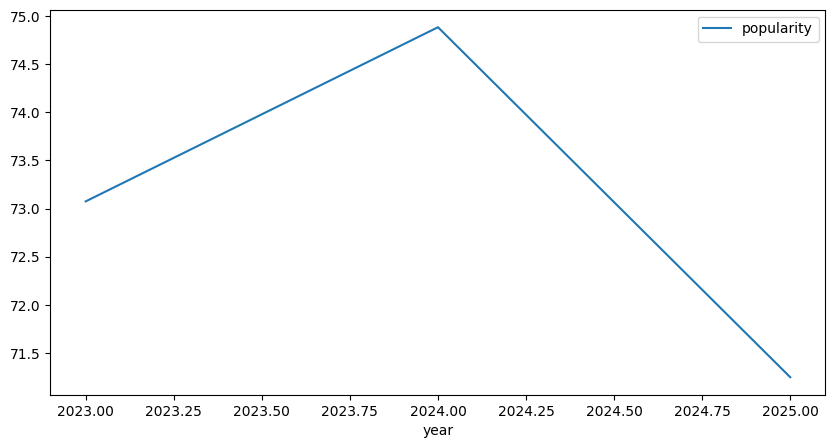

In [274]:
sql  ='SELECT strftime("%Y", datetime("snapshot_date")) as pop_year, strftime("%Y", datetime("album_release_date")) as release_year, AVG(popularity) as popularity FROM songs GROUP BY pop_year, release_year ORDER BY pop_year ASC, release_year ASC'

cur.execute(sql)
rows = cur.fetchall()

tmp_df = pd.DataFrame(rows)
tmp_df.columns = ["year", "release", "popularity" ]
tmp_df["year"] = pd.to_numeric(tmp_df["year"], downcast="integer")
tmp_df["release"] = pd.to_numeric(tmp_df["release"], downcast="integer")
tmp_df["popularity"] = pd.to_numeric(tmp_df["popularity"])
tmp_df.set_index("year", inplace=True)

tmp_df["release"] = pd.to_numeric(tmp_df["release"])
tmp_df = tmp_df.loc[(tmp_df["release"]>=1980) & (tmp_df["release"]<1990), "popularity"].reset_index().groupby("year").mean()
display(tmp_df)
tmp_df.plot(kind='line', stacked=True, figsize=(10,5), y="popularity")